In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


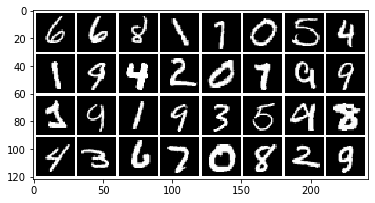

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Magnitude:


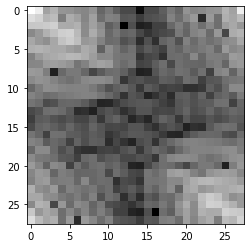

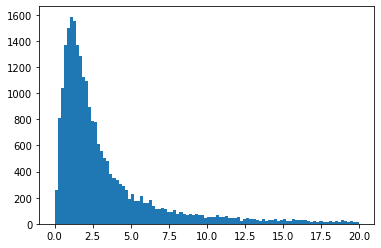

Phase:


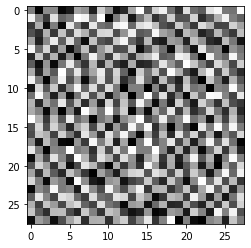

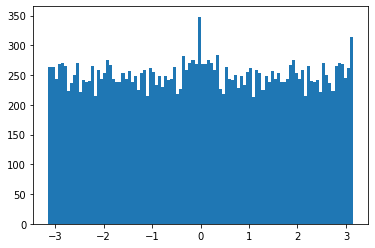

In [6]:
# Value distributions of magnitude and phase for the first sample

print("Magnitude:")
plot_magn(sample_magnitudes[0, 0])
plt.hist(sample_magnitudes.reshape(-1), bins=100, range=(0, 20))
plt.show()
print("Phase:")
plot_phase(sample_phases[0, 0])
plt.hist(sample_phases.reshape(-1), bins=100)
plt.show()

In [7]:
# Check for shapes of rfft transformation in Fourier and signal domain

sample_ft1 = torch.rfft(sample, 2, onesided=True)
print(sample_ft1.shape)
sample1 = torch.irfft(sample_ft1, 2, onesided=True, signal_sizes=(28, 28))
print(sample1[0].shape)

torch.Size([32, 1, 28, 15, 2])
torch.Size([1, 28, 28])


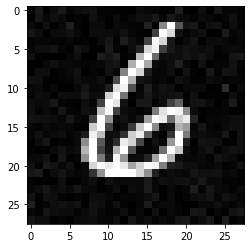

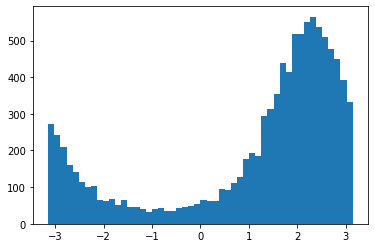

In [8]:
# Show how a small change in the signal space can disturb a specific phase
noise_level = 0.05
########
plot(sample[0] + noise_level * torch.abs(torch.randn(sample[0].shape)))

ph0 = []
for i in range(10000):
    ft = torch.rfft(sample[0] + noise_level * torch.randn(sample[0].shape), 2, onesided=True)
    ph0.append(torch.atan2(ft[..., 1], ft[..., 0])[0, 10, 10])
    
plt.hist(ph0, bins=50)
plt.show()

Gaussian in the signal domain cause Gaussian noise for the phases. But circular!

---

In [9]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2] * self.outsize[3]),
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [10]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return mags, phs

In [11]:
# Define loss

def gen_loss(magn, pred_vec, phase):
    vec = torch.stack([torch.cos(phase), torch.sin(phase)], dim=-1)
    return  torch.mean((magn ** 2) * torch.sum((vec - pred_vec) ** 2, -1))

#def gen_loss(magn, pred_vec, phase):
#    vec = torch.stack([torch.cos(phase), torch.sin(phase)], dim=-1)
#    return  torch.mean(torch.sum((vec - pred_vec) ** 2, -1))

In [12]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28, 2), h=2048)

Version 0.4


In [13]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [14]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magn, sample_phs = calc_fourier(sample)

pred_vec = gen(sample_magn)

loss = gen_loss(sample_magn, pred_vec, sample_phs)

print("Generator loss:", loss.item())

Generator loss: 96.87617492675781


In [16]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            magn, phs = calc_fourier(x)

            # compute loss as pixel wise distance to original input
            pred_vec = model(magn)
            
            loss = gen_loss(magn, pred_vec, phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 94.2
epoch:  1 	 step:100 	 loss: 38.6
epoch:  1 	 step:200 	 loss: 30.03
epoch:  1 	 step:300 	 loss: 29.16
epoch:  1 	 step:400 	 loss: 27.03
epoch:  1 	 step:500 	 loss: 33.1
epoch:  1 	 step:600 	 loss: 25.34
epoch:  1 	 step:700 	 loss: 26.65
epoch:  1 	 step:800 	 loss: 25.25
epoch:  1 	 step:900 	 loss: 31.63
epoch:  1 	 step:1000 	 loss: 22.0
epoch:  1 	 step:1100 	 loss: 27.44
epoch:  1 	 step:1200 	 loss: 23.52
epoch:  1 	 step:1300 	 loss: 24.95
epoch:  1 	 step:1400 	 loss: 25.43
epoch:  1 	 step:1500 	 loss: 24.93
epoch:  1 	 step:1600 	 loss: 28.49
epoch:  1 	 step:1700 	 loss: 21.29
epoch:  1 	 step:1800 	 loss: 22.38


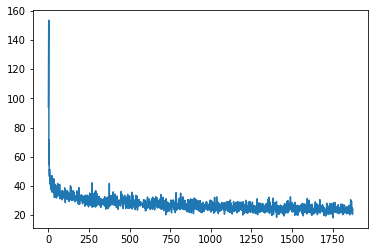

epoch:  2 	 step:0 	 loss: 18.95
epoch:  2 	 step:100 	 loss: 21.73
epoch:  2 	 step:200 	 loss: 21.24
epoch:  2 	 step:300 	 loss: 21.95
epoch:  2 	 step:400 	 loss: 18.97
epoch:  2 	 step:500 	 loss: 20.59
epoch:  2 	 step:600 	 loss: 18.8
epoch:  2 	 step:700 	 loss: 20.33
epoch:  2 	 step:800 	 loss: 20.62
epoch:  2 	 step:900 	 loss: 26.48
epoch:  2 	 step:1000 	 loss: 20.71
epoch:  2 	 step:1100 	 loss: 23.86
epoch:  2 	 step:1200 	 loss: 19.49
epoch:  2 	 step:1300 	 loss: 20.52
epoch:  2 	 step:1400 	 loss: 19.47
epoch:  2 	 step:1500 	 loss: 21.94
epoch:  2 	 step:1600 	 loss: 22.94
epoch:  2 	 step:1700 	 loss: 21.52
epoch:  2 	 step:1800 	 loss: 22.32


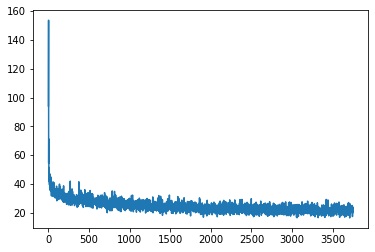

epoch:  3 	 step:0 	 loss: 20.93
epoch:  3 	 step:100 	 loss: 23.57
epoch:  3 	 step:200 	 loss: 20.31
epoch:  3 	 step:300 	 loss: 19.06
epoch:  3 	 step:400 	 loss: 21.11
epoch:  3 	 step:500 	 loss: 18.55
epoch:  3 	 step:600 	 loss: 19.03
epoch:  3 	 step:700 	 loss: 18.95
epoch:  3 	 step:800 	 loss: 19.24
epoch:  3 	 step:900 	 loss: 19.92
epoch:  3 	 step:1000 	 loss: 19.19
epoch:  3 	 step:1100 	 loss: 17.29
epoch:  3 	 step:1200 	 loss: 23.64
epoch:  3 	 step:1300 	 loss: 19.23
epoch:  3 	 step:1400 	 loss: 20.65
epoch:  3 	 step:1500 	 loss: 20.41
epoch:  3 	 step:1600 	 loss: 20.37
epoch:  3 	 step:1700 	 loss: 22.37
epoch:  3 	 step:1800 	 loss: 20.17


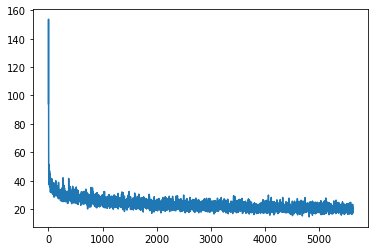

epoch:  4 	 step:0 	 loss: 20.93
epoch:  4 	 step:100 	 loss: 18.55
epoch:  4 	 step:200 	 loss: 19.33
epoch:  4 	 step:300 	 loss: 19.65
epoch:  4 	 step:400 	 loss: 17.48
epoch:  4 	 step:500 	 loss: 19.11
epoch:  4 	 step:600 	 loss: 19.31
epoch:  4 	 step:700 	 loss: 20.32
epoch:  4 	 step:800 	 loss: 20.37
epoch:  4 	 step:900 	 loss: 18.35
epoch:  4 	 step:1000 	 loss: 18.02
epoch:  4 	 step:1100 	 loss: 19.41
epoch:  4 	 step:1200 	 loss: 20.18
epoch:  4 	 step:1300 	 loss: 18.15
epoch:  4 	 step:1400 	 loss: 22.18
epoch:  4 	 step:1500 	 loss: 22.03
epoch:  4 	 step:1600 	 loss: 21.11
epoch:  4 	 step:1700 	 loss: 15.25
epoch:  4 	 step:1800 	 loss: 16.65


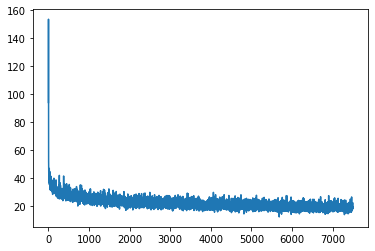

epoch:  5 	 step:0 	 loss: 20.28
epoch:  5 	 step:100 	 loss: 17.34
epoch:  5 	 step:200 	 loss: 17.53
epoch:  5 	 step:300 	 loss: 16.49
epoch:  5 	 step:400 	 loss: 19.25
epoch:  5 	 step:500 	 loss: 17.49
epoch:  5 	 step:600 	 loss: 15.67
epoch:  5 	 step:700 	 loss: 15.67
epoch:  5 	 step:800 	 loss: 17.14
epoch:  5 	 step:900 	 loss: 21.65
epoch:  5 	 step:1000 	 loss: 17.83
epoch:  5 	 step:1100 	 loss: 18.58
epoch:  5 	 step:1200 	 loss: 18.31
epoch:  5 	 step:1300 	 loss: 18.37
epoch:  5 	 step:1400 	 loss: 19.62
epoch:  5 	 step:1500 	 loss: 21.1
epoch:  5 	 step:1600 	 loss: 20.68
epoch:  5 	 step:1700 	 loss: 16.71
epoch:  5 	 step:1800 	 loss: 16.98


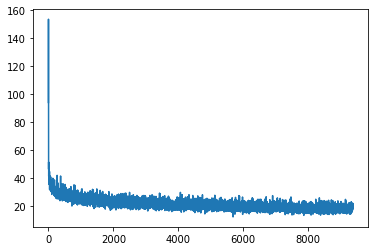

epoch:  6 	 step:0 	 loss: 15.37
epoch:  6 	 step:100 	 loss: 20.81
epoch:  6 	 step:200 	 loss: 18.29
epoch:  6 	 step:300 	 loss: 18.19
epoch:  6 	 step:400 	 loss: 16.75
epoch:  6 	 step:500 	 loss: 17.64
epoch:  6 	 step:600 	 loss: 20.76
epoch:  6 	 step:700 	 loss: 19.68
epoch:  6 	 step:800 	 loss: 15.94
epoch:  6 	 step:900 	 loss: 15.77
epoch:  6 	 step:1000 	 loss: 18.51
epoch:  6 	 step:1100 	 loss: 18.56
epoch:  6 	 step:1200 	 loss: 18.94
epoch:  6 	 step:1300 	 loss: 22.48
epoch:  6 	 step:1400 	 loss: 15.03
epoch:  6 	 step:1500 	 loss: 18.22
epoch:  6 	 step:1600 	 loss: 16.8
epoch:  6 	 step:1700 	 loss: 19.36
epoch:  6 	 step:1800 	 loss: 19.52


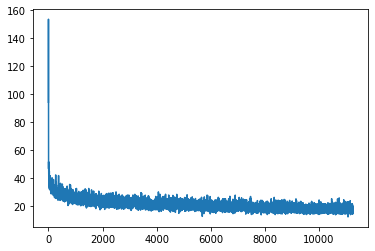

epoch:  7 	 step:0 	 loss: 16.35
epoch:  7 	 step:100 	 loss: 17.7
epoch:  7 	 step:200 	 loss: 15.01
epoch:  7 	 step:300 	 loss: 18.28
epoch:  7 	 step:400 	 loss: 17.4
epoch:  7 	 step:500 	 loss: 17.95
epoch:  7 	 step:600 	 loss: 15.14
epoch:  7 	 step:700 	 loss: 13.83
epoch:  7 	 step:800 	 loss: 18.15
epoch:  7 	 step:900 	 loss: 17.4
epoch:  7 	 step:1000 	 loss: 16.82
epoch:  7 	 step:1100 	 loss: 16.13
epoch:  7 	 step:1200 	 loss: 18.17
epoch:  7 	 step:1300 	 loss: 16.8
epoch:  7 	 step:1400 	 loss: 17.4
epoch:  7 	 step:1500 	 loss: 15.36
epoch:  7 	 step:1600 	 loss: 18.69
epoch:  7 	 step:1700 	 loss: 17.49
epoch:  7 	 step:1800 	 loss: 15.64


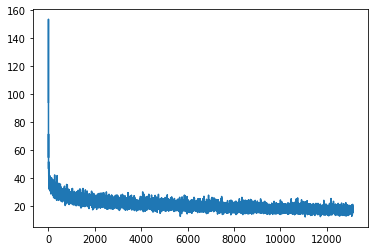

epoch:  8 	 step:0 	 loss: 15.58
epoch:  8 	 step:100 	 loss: 15.22
epoch:  8 	 step:200 	 loss: 14.99
epoch:  8 	 step:300 	 loss: 15.21
epoch:  8 	 step:400 	 loss: 15.31
epoch:  8 	 step:500 	 loss: 16.21
epoch:  8 	 step:600 	 loss: 14.57
epoch:  8 	 step:700 	 loss: 19.58
epoch:  8 	 step:800 	 loss: 18.89
epoch:  8 	 step:900 	 loss: 16.98
epoch:  8 	 step:1000 	 loss: 17.7
epoch:  8 	 step:1100 	 loss: 17.41
epoch:  8 	 step:1200 	 loss: 16.4
epoch:  8 	 step:1300 	 loss: 16.17
epoch:  8 	 step:1400 	 loss: 15.21
epoch:  8 	 step:1500 	 loss: 14.29
epoch:  8 	 step:1600 	 loss: 19.88
epoch:  8 	 step:1700 	 loss: 15.15
epoch:  8 	 step:1800 	 loss: 16.27


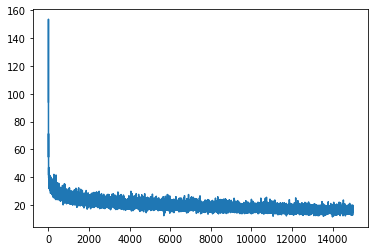

epoch:  9 	 step:0 	 loss: 14.37
epoch:  9 	 step:100 	 loss: 13.5
epoch:  9 	 step:200 	 loss: 14.84
epoch:  9 	 step:300 	 loss: 15.84
epoch:  9 	 step:400 	 loss: 15.61
epoch:  9 	 step:500 	 loss: 13.94
epoch:  9 	 step:600 	 loss: 19.69
epoch:  9 	 step:700 	 loss: 15.98
epoch:  9 	 step:800 	 loss: 15.14
epoch:  9 	 step:900 	 loss: 14.83
epoch:  9 	 step:1000 	 loss: 16.38
epoch:  9 	 step:1100 	 loss: 14.21
epoch:  9 	 step:1200 	 loss: 15.74
epoch:  9 	 step:1300 	 loss: 19.05
epoch:  9 	 step:1400 	 loss: 15.21
epoch:  9 	 step:1500 	 loss: 18.97
epoch:  9 	 step:1600 	 loss: 13.87
epoch:  9 	 step:1700 	 loss: 14.65
epoch:  9 	 step:1800 	 loss: 16.32


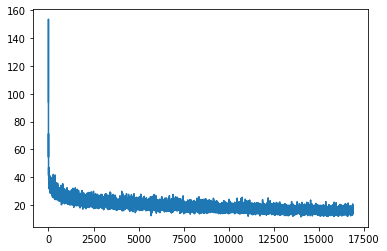

epoch: 10 	 step:0 	 loss: 16.19
epoch: 10 	 step:100 	 loss: 15.39
epoch: 10 	 step:200 	 loss: 18.06
epoch: 10 	 step:300 	 loss: 15.4
epoch: 10 	 step:400 	 loss: 17.94
epoch: 10 	 step:500 	 loss: 16.12
epoch: 10 	 step:600 	 loss: 16.77
epoch: 10 	 step:700 	 loss: 14.88
epoch: 10 	 step:800 	 loss: 16.46
epoch: 10 	 step:900 	 loss: 15.31
epoch: 10 	 step:1000 	 loss: 16.87
epoch: 10 	 step:1100 	 loss: 18.0
epoch: 10 	 step:1200 	 loss: 15.38
epoch: 10 	 step:1300 	 loss: 14.28
epoch: 10 	 step:1400 	 loss: 13.47
epoch: 10 	 step:1500 	 loss: 16.86
epoch: 10 	 step:1600 	 loss: 12.3
epoch: 10 	 step:1700 	 loss: 15.01
epoch: 10 	 step:1800 	 loss: 15.21


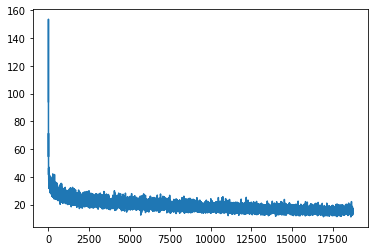

epoch: 11 	 step:0 	 loss: 14.38
epoch: 11 	 step:100 	 loss: 13.71
epoch: 11 	 step:200 	 loss: 15.47
epoch: 11 	 step:300 	 loss: 17.98
epoch: 11 	 step:400 	 loss: 14.37
epoch: 11 	 step:500 	 loss: 17.49
epoch: 11 	 step:600 	 loss: 16.62
epoch: 11 	 step:700 	 loss: 13.51
epoch: 11 	 step:800 	 loss: 14.54
epoch: 11 	 step:900 	 loss: 14.98
epoch: 11 	 step:1000 	 loss: 14.72
epoch: 11 	 step:1100 	 loss: 15.97
epoch: 11 	 step:1200 	 loss: 13.57
epoch: 11 	 step:1300 	 loss: 11.67
epoch: 11 	 step:1400 	 loss: 14.13
epoch: 11 	 step:1500 	 loss: 13.43
epoch: 11 	 step:1600 	 loss: 14.26
epoch: 11 	 step:1700 	 loss: 13.67
epoch: 11 	 step:1800 	 loss: 15.86


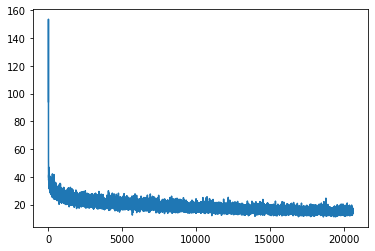

epoch: 12 	 step:0 	 loss: 14.88
epoch: 12 	 step:100 	 loss: 13.63
epoch: 12 	 step:200 	 loss: 15.83
epoch: 12 	 step:300 	 loss: 15.72
epoch: 12 	 step:400 	 loss: 14.22
epoch: 12 	 step:500 	 loss: 12.67
epoch: 12 	 step:600 	 loss: 17.18
epoch: 12 	 step:700 	 loss: 14.01
epoch: 12 	 step:800 	 loss: 13.51
epoch: 12 	 step:900 	 loss: 13.7
epoch: 12 	 step:1000 	 loss: 14.05
epoch: 12 	 step:1100 	 loss: 14.0
epoch: 12 	 step:1200 	 loss: 14.57
epoch: 12 	 step:1300 	 loss: 15.18
epoch: 12 	 step:1400 	 loss: 12.68
epoch: 12 	 step:1500 	 loss: 12.57
epoch: 12 	 step:1600 	 loss: 18.25
epoch: 12 	 step:1700 	 loss: 14.16
epoch: 12 	 step:1800 	 loss: 12.89


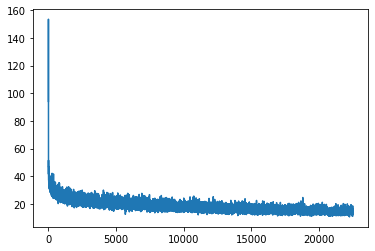

epoch: 13 	 step:0 	 loss: 16.47
epoch: 13 	 step:100 	 loss: 13.21
epoch: 13 	 step:200 	 loss: 13.44
epoch: 13 	 step:300 	 loss: 12.9
epoch: 13 	 step:400 	 loss: 13.9
epoch: 13 	 step:500 	 loss: 16.32
epoch: 13 	 step:600 	 loss: 14.11
epoch: 13 	 step:700 	 loss: 13.39
epoch: 13 	 step:800 	 loss: 13.1
epoch: 13 	 step:900 	 loss: 16.32
epoch: 13 	 step:1000 	 loss: 12.78
epoch: 13 	 step:1100 	 loss: 13.68
epoch: 13 	 step:1200 	 loss: 15.04
epoch: 13 	 step:1300 	 loss: 16.03
epoch: 13 	 step:1400 	 loss: 13.0
epoch: 13 	 step:1500 	 loss: 12.83
epoch: 13 	 step:1600 	 loss: 10.93
epoch: 13 	 step:1700 	 loss: 14.26
epoch: 13 	 step:1800 	 loss: 14.58


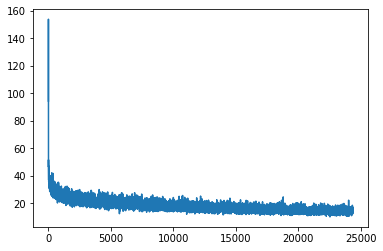

epoch: 14 	 step:0 	 loss: 12.15
epoch: 14 	 step:100 	 loss: 11.2
epoch: 14 	 step:200 	 loss: 12.12
epoch: 14 	 step:300 	 loss: 13.46
epoch: 14 	 step:400 	 loss: 14.27
epoch: 14 	 step:500 	 loss: 14.78
epoch: 14 	 step:600 	 loss: 15.0
epoch: 14 	 step:700 	 loss: 14.55
epoch: 14 	 step:800 	 loss: 11.95
epoch: 14 	 step:900 	 loss: 12.93
epoch: 14 	 step:1000 	 loss: 15.56
epoch: 14 	 step:1100 	 loss: 14.18
epoch: 14 	 step:1200 	 loss: 14.84
epoch: 14 	 step:1300 	 loss: 14.81
epoch: 14 	 step:1400 	 loss: 12.85
epoch: 14 	 step:1500 	 loss: 12.74
epoch: 14 	 step:1600 	 loss: 13.59
epoch: 14 	 step:1700 	 loss: 15.89
epoch: 14 	 step:1800 	 loss: 12.98


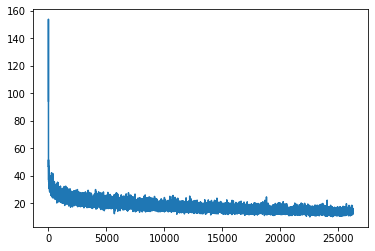

epoch: 15 	 step:0 	 loss: 13.06
epoch: 15 	 step:100 	 loss: 15.32
epoch: 15 	 step:200 	 loss: 11.74
epoch: 15 	 step:300 	 loss: 12.94
epoch: 15 	 step:400 	 loss: 13.39
epoch: 15 	 step:500 	 loss: 14.37
epoch: 15 	 step:600 	 loss: 13.75
epoch: 15 	 step:700 	 loss: 12.01
epoch: 15 	 step:800 	 loss: 12.23
epoch: 15 	 step:900 	 loss: 13.01
epoch: 15 	 step:1000 	 loss: 12.09
epoch: 15 	 step:1100 	 loss: 13.16
epoch: 15 	 step:1200 	 loss: 11.27
epoch: 15 	 step:1300 	 loss: 13.21
epoch: 15 	 step:1400 	 loss: 13.41
epoch: 15 	 step:1500 	 loss: 12.9
epoch: 15 	 step:1600 	 loss: 15.51
epoch: 15 	 step:1700 	 loss: 15.22
epoch: 15 	 step:1800 	 loss: 14.64


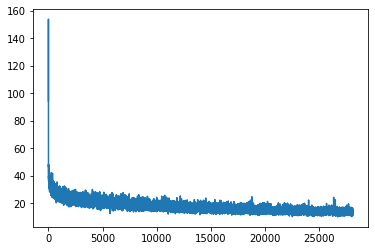

epoch: 16 	 step:0 	 loss: 12.13
epoch: 16 	 step:100 	 loss: 11.24
epoch: 16 	 step:200 	 loss: 11.62
epoch: 16 	 step:300 	 loss: 14.03
epoch: 16 	 step:400 	 loss: 14.14
epoch: 16 	 step:500 	 loss: 10.84
epoch: 16 	 step:600 	 loss: 13.99
epoch: 16 	 step:700 	 loss: 11.19
epoch: 16 	 step:800 	 loss: 13.82
epoch: 16 	 step:900 	 loss: 13.06
epoch: 16 	 step:1000 	 loss: 14.52
epoch: 16 	 step:1100 	 loss: 13.89
epoch: 16 	 step:1200 	 loss: 12.85
epoch: 16 	 step:1300 	 loss: 13.1
epoch: 16 	 step:1400 	 loss: 16.56
epoch: 16 	 step:1500 	 loss: 11.04
epoch: 16 	 step:1600 	 loss: 11.83
epoch: 16 	 step:1700 	 loss: 13.52
epoch: 16 	 step:1800 	 loss: 13.71


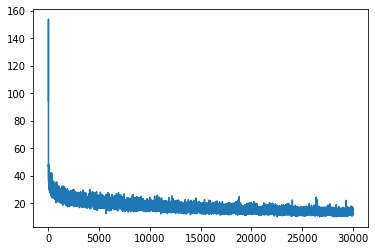

epoch: 17 	 step:0 	 loss: 13.67
epoch: 17 	 step:100 	 loss: 11.78
epoch: 17 	 step:200 	 loss: 11.93
epoch: 17 	 step:300 	 loss: 12.99
epoch: 17 	 step:400 	 loss: 11.36
epoch: 17 	 step:500 	 loss: 11.36
epoch: 17 	 step:600 	 loss: 15.06
epoch: 17 	 step:700 	 loss: 12.08
epoch: 17 	 step:800 	 loss: 11.86
epoch: 17 	 step:900 	 loss: 12.79
epoch: 17 	 step:1000 	 loss: 12.74
epoch: 17 	 step:1100 	 loss: 12.81
epoch: 17 	 step:1200 	 loss: 13.49
epoch: 17 	 step:1300 	 loss: 13.23
epoch: 17 	 step:1400 	 loss: 14.08
epoch: 17 	 step:1500 	 loss: 12.86
epoch: 17 	 step:1600 	 loss: 14.85
epoch: 17 	 step:1700 	 loss: 12.78
epoch: 17 	 step:1800 	 loss: 13.27


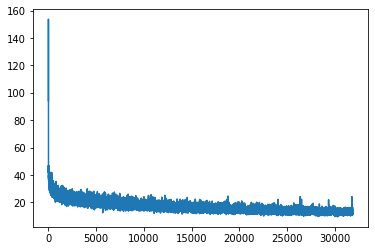

epoch: 18 	 step:0 	 loss: 12.9
epoch: 18 	 step:100 	 loss: 14.03
epoch: 18 	 step:200 	 loss: 12.86
epoch: 18 	 step:300 	 loss: 13.22
epoch: 18 	 step:400 	 loss: 11.03
epoch: 18 	 step:500 	 loss: 12.28
epoch: 18 	 step:600 	 loss: 15.65
epoch: 18 	 step:700 	 loss: 11.5
epoch: 18 	 step:800 	 loss: 10.36
epoch: 18 	 step:900 	 loss: 13.27
epoch: 18 	 step:1000 	 loss: 12.93
epoch: 18 	 step:1100 	 loss: 12.13
epoch: 18 	 step:1200 	 loss: 12.59
epoch: 18 	 step:1300 	 loss: 13.17
epoch: 18 	 step:1400 	 loss: 11.65
epoch: 18 	 step:1500 	 loss: 13.09
epoch: 18 	 step:1600 	 loss: 12.65
epoch: 18 	 step:1700 	 loss: 12.39
epoch: 18 	 step:1800 	 loss: 13.78


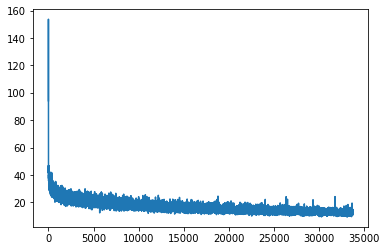

epoch: 19 	 step:0 	 loss: 11.03
epoch: 19 	 step:100 	 loss: 11.93
epoch: 19 	 step:200 	 loss: 12.13
epoch: 19 	 step:300 	 loss: 10.62
epoch: 19 	 step:400 	 loss: 12.7
epoch: 19 	 step:500 	 loss: 12.17
epoch: 19 	 step:600 	 loss: 13.14
epoch: 19 	 step:700 	 loss: 13.64
epoch: 19 	 step:800 	 loss: 11.8
epoch: 19 	 step:900 	 loss: 11.64
epoch: 19 	 step:1000 	 loss: 12.09
epoch: 19 	 step:1100 	 loss: 13.26
epoch: 19 	 step:1200 	 loss: 13.13
epoch: 19 	 step:1300 	 loss: 11.42
epoch: 19 	 step:1400 	 loss: 12.69
epoch: 19 	 step:1500 	 loss: 11.34
epoch: 19 	 step:1600 	 loss: 14.17
epoch: 19 	 step:1700 	 loss: 13.92
epoch: 19 	 step:1800 	 loss: 12.87


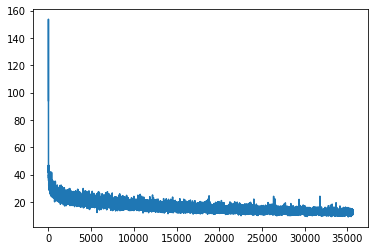

epoch: 20 	 step:0 	 loss: 11.08
epoch: 20 	 step:100 	 loss: 13.54
epoch: 20 	 step:200 	 loss: 11.12
epoch: 20 	 step:300 	 loss: 9.557
epoch: 20 	 step:400 	 loss: 11.78
epoch: 20 	 step:500 	 loss: 11.84
epoch: 20 	 step:600 	 loss: 9.692
epoch: 20 	 step:700 	 loss: 11.65
epoch: 20 	 step:800 	 loss: 11.02
epoch: 20 	 step:900 	 loss: 12.47
epoch: 20 	 step:1000 	 loss: 10.98
epoch: 20 	 step:1100 	 loss: 10.81
epoch: 20 	 step:1200 	 loss: 11.5
epoch: 20 	 step:1300 	 loss: 13.34
epoch: 20 	 step:1400 	 loss: 11.76
epoch: 20 	 step:1500 	 loss: 11.16
epoch: 20 	 step:1600 	 loss: 11.72
epoch: 20 	 step:1700 	 loss: 11.31
epoch: 20 	 step:1800 	 loss: 12.32


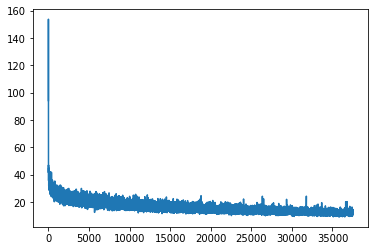

epoch: 21 	 step:0 	 loss: 10.38
epoch: 21 	 step:100 	 loss: 12.25
epoch: 21 	 step:200 	 loss: 10.56
epoch: 21 	 step:300 	 loss: 10.44
epoch: 21 	 step:400 	 loss: 12.29
epoch: 21 	 step:500 	 loss: 11.7
epoch: 21 	 step:600 	 loss: 13.3
epoch: 21 	 step:700 	 loss: 12.49
epoch: 21 	 step:800 	 loss: 12.76
epoch: 21 	 step:900 	 loss: 10.59
epoch: 21 	 step:1000 	 loss: 12.18
epoch: 21 	 step:1100 	 loss: 11.69
epoch: 21 	 step:1200 	 loss: 14.04
epoch: 21 	 step:1300 	 loss: 12.79
epoch: 21 	 step:1400 	 loss: 12.17
epoch: 21 	 step:1500 	 loss: 13.36
epoch: 21 	 step:1600 	 loss: 11.78
epoch: 21 	 step:1700 	 loss: 12.91
epoch: 21 	 step:1800 	 loss: 12.89


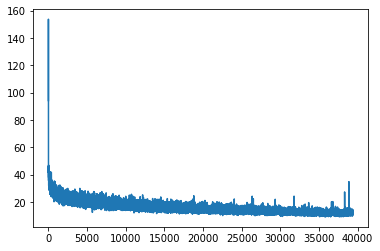

epoch: 22 	 step:0 	 loss: 10.42
epoch: 22 	 step:100 	 loss: 11.23
epoch: 22 	 step:200 	 loss: 11.44
epoch: 22 	 step:300 	 loss: 11.63
epoch: 22 	 step:400 	 loss: 8.836
epoch: 22 	 step:500 	 loss: 13.04
epoch: 22 	 step:600 	 loss: 12.09
epoch: 22 	 step:700 	 loss: 10.74
epoch: 22 	 step:800 	 loss: 12.62
epoch: 22 	 step:900 	 loss: 13.19
epoch: 22 	 step:1000 	 loss: 11.01
epoch: 22 	 step:1100 	 loss: 12.65
epoch: 22 	 step:1200 	 loss: 13.84
epoch: 22 	 step:1300 	 loss: 12.55
epoch: 22 	 step:1400 	 loss: 12.02
epoch: 22 	 step:1500 	 loss: 11.79
epoch: 22 	 step:1600 	 loss: 11.19
epoch: 22 	 step:1700 	 loss: 11.4
epoch: 22 	 step:1800 	 loss: 11.92


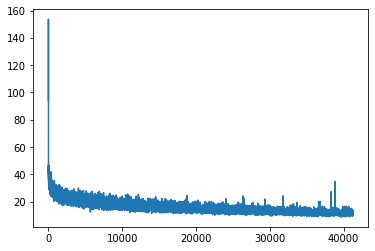

epoch: 23 	 step:0 	 loss: 10.34
epoch: 23 	 step:100 	 loss: 10.14
epoch: 23 	 step:200 	 loss: 10.49
epoch: 23 	 step:300 	 loss: 13.2
epoch: 23 	 step:400 	 loss: 10.47
epoch: 23 	 step:500 	 loss: 10.45
epoch: 23 	 step:600 	 loss: 10.78
epoch: 23 	 step:700 	 loss: 10.43
epoch: 23 	 step:800 	 loss: 12.48
epoch: 23 	 step:900 	 loss: 11.55
epoch: 23 	 step:1000 	 loss: 14.22
epoch: 23 	 step:1100 	 loss: 10.59
epoch: 23 	 step:1200 	 loss: 11.2
epoch: 23 	 step:1300 	 loss: 11.98
epoch: 23 	 step:1400 	 loss: 11.7
epoch: 23 	 step:1500 	 loss: 12.36
epoch: 23 	 step:1600 	 loss: 13.31
epoch: 23 	 step:1700 	 loss: 10.55
epoch: 23 	 step:1800 	 loss: 10.28


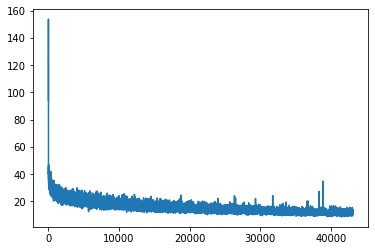

epoch: 24 	 step:0 	 loss: 10.69
epoch: 24 	 step:100 	 loss: 15.45
epoch: 24 	 step:200 	 loss: 11.34
epoch: 24 	 step:300 	 loss: 10.12
epoch: 24 	 step:400 	 loss: 10.44
epoch: 24 	 step:500 	 loss: 10.14
epoch: 24 	 step:600 	 loss: 11.61
epoch: 24 	 step:700 	 loss: 10.92
epoch: 24 	 step:800 	 loss: 10.0
epoch: 24 	 step:900 	 loss: 12.11
epoch: 24 	 step:1000 	 loss: 11.72
epoch: 24 	 step:1100 	 loss: 11.32
epoch: 24 	 step:1200 	 loss: 9.312
epoch: 24 	 step:1300 	 loss: 10.93
epoch: 24 	 step:1400 	 loss: 10.8
epoch: 24 	 step:1500 	 loss: 10.27
epoch: 24 	 step:1600 	 loss: 11.16
epoch: 24 	 step:1700 	 loss: 12.31
epoch: 24 	 step:1800 	 loss: 11.38


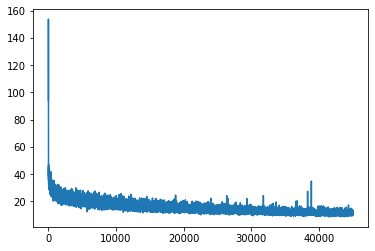

epoch: 25 	 step:0 	 loss: 13.14
epoch: 25 	 step:100 	 loss: 9.268
epoch: 25 	 step:200 	 loss: 10.6
epoch: 25 	 step:300 	 loss: 11.0
epoch: 25 	 step:400 	 loss: 11.49
epoch: 25 	 step:500 	 loss: 10.9
epoch: 25 	 step:600 	 loss: 11.24
epoch: 25 	 step:700 	 loss: 11.08
epoch: 25 	 step:800 	 loss: 9.978
epoch: 25 	 step:900 	 loss: 10.29
epoch: 25 	 step:1000 	 loss: 10.42
epoch: 25 	 step:1100 	 loss: 11.4
epoch: 25 	 step:1200 	 loss: 12.25
epoch: 25 	 step:1300 	 loss: 12.3
epoch: 25 	 step:1400 	 loss: 10.21
epoch: 25 	 step:1500 	 loss: 9.922
epoch: 25 	 step:1600 	 loss: 10.95
epoch: 25 	 step:1700 	 loss: 10.94
epoch: 25 	 step:1800 	 loss: 10.5


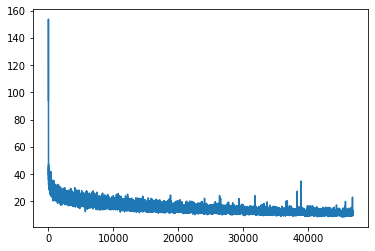

epoch: 26 	 step:0 	 loss: 10.52
epoch: 26 	 step:100 	 loss: 10.13
epoch: 26 	 step:200 	 loss: 10.05
epoch: 26 	 step:300 	 loss: 9.469
epoch: 26 	 step:400 	 loss: 14.52
epoch: 26 	 step:500 	 loss: 11.75
epoch: 26 	 step:600 	 loss: 11.03
epoch: 26 	 step:700 	 loss: 10.88
epoch: 26 	 step:800 	 loss: 11.45
epoch: 26 	 step:900 	 loss: 9.879
epoch: 26 	 step:1000 	 loss: 11.01
epoch: 26 	 step:1100 	 loss: 11.52
epoch: 26 	 step:1200 	 loss: 11.17
epoch: 26 	 step:1300 	 loss: 9.838
epoch: 26 	 step:1400 	 loss: 9.589
epoch: 26 	 step:1500 	 loss: 9.321
epoch: 26 	 step:1600 	 loss: 10.28
epoch: 26 	 step:1700 	 loss: 10.47
epoch: 26 	 step:1800 	 loss: 11.85


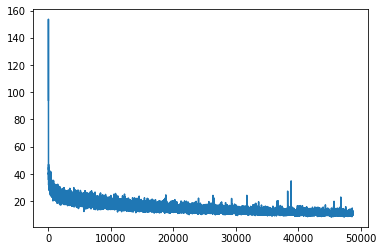

epoch: 27 	 step:0 	 loss: 9.63
epoch: 27 	 step:100 	 loss: 11.3
epoch: 27 	 step:200 	 loss: 10.26
epoch: 27 	 step:300 	 loss: 9.784
epoch: 27 	 step:400 	 loss: 10.15
epoch: 27 	 step:500 	 loss: 10.57
epoch: 27 	 step:600 	 loss: 10.0
epoch: 27 	 step:700 	 loss: 11.2
epoch: 27 	 step:800 	 loss: 9.649
epoch: 27 	 step:900 	 loss: 9.936
epoch: 27 	 step:1000 	 loss: 10.54
epoch: 27 	 step:1100 	 loss: 9.99
epoch: 27 	 step:1200 	 loss: 10.87
epoch: 27 	 step:1300 	 loss: 10.5
epoch: 27 	 step:1400 	 loss: 9.664
epoch: 27 	 step:1500 	 loss: 9.295
epoch: 27 	 step:1600 	 loss: 10.02
epoch: 27 	 step:1700 	 loss: 11.8
epoch: 27 	 step:1800 	 loss: 9.755


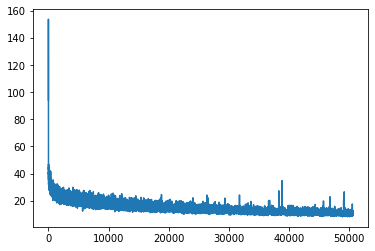

epoch: 28 	 step:0 	 loss: 10.35
epoch: 28 	 step:100 	 loss: 8.496
epoch: 28 	 step:200 	 loss: 10.18
epoch: 28 	 step:300 	 loss: 10.56
epoch: 28 	 step:400 	 loss: 11.14
epoch: 28 	 step:500 	 loss: 10.66
epoch: 28 	 step:600 	 loss: 10.49
epoch: 28 	 step:700 	 loss: 10.71
epoch: 28 	 step:800 	 loss: 10.23
epoch: 28 	 step:900 	 loss: 10.72
epoch: 28 	 step:1000 	 loss: 12.23
epoch: 28 	 step:1100 	 loss: 10.34
epoch: 28 	 step:1200 	 loss: 10.84
epoch: 28 	 step:1300 	 loss: 10.91
epoch: 28 	 step:1400 	 loss: 10.47
epoch: 28 	 step:1500 	 loss: 10.53
epoch: 28 	 step:1600 	 loss: 10.52
epoch: 28 	 step:1700 	 loss: 9.715
epoch: 28 	 step:1800 	 loss: 9.571


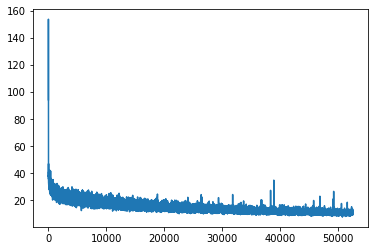

epoch: 29 	 step:0 	 loss: 10.21
epoch: 29 	 step:100 	 loss: 9.653
epoch: 29 	 step:200 	 loss: 10.43
epoch: 29 	 step:300 	 loss: 10.26
epoch: 29 	 step:400 	 loss: 8.935
epoch: 29 	 step:500 	 loss: 10.45
epoch: 29 	 step:600 	 loss: 9.372
epoch: 29 	 step:700 	 loss: 10.27
epoch: 29 	 step:800 	 loss: 9.431
epoch: 29 	 step:900 	 loss: 8.922
epoch: 29 	 step:1000 	 loss: 9.913
epoch: 29 	 step:1100 	 loss: 10.26
epoch: 29 	 step:1200 	 loss: 10.27
epoch: 29 	 step:1300 	 loss: 10.08
epoch: 29 	 step:1400 	 loss: 9.715
epoch: 29 	 step:1500 	 loss: 10.8
epoch: 29 	 step:1600 	 loss: 10.8
epoch: 29 	 step:1700 	 loss: 11.05
epoch: 29 	 step:1800 	 loss: 9.615


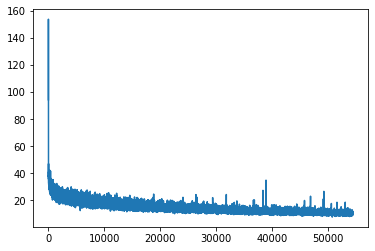

epoch: 30 	 step:0 	 loss: 9.304
epoch: 30 	 step:100 	 loss: 9.289
epoch: 30 	 step:200 	 loss: 8.892
epoch: 30 	 step:300 	 loss: 10.07
epoch: 30 	 step:400 	 loss: 8.519
epoch: 30 	 step:500 	 loss: 8.776
epoch: 30 	 step:600 	 loss: 9.742
epoch: 30 	 step:700 	 loss: 11.34
epoch: 30 	 step:800 	 loss: 11.58
epoch: 30 	 step:900 	 loss: 10.08
epoch: 30 	 step:1000 	 loss: 10.69
epoch: 30 	 step:1100 	 loss: 10.86
epoch: 30 	 step:1200 	 loss: 9.799
epoch: 30 	 step:1300 	 loss: 10.47
epoch: 30 	 step:1400 	 loss: 9.182
epoch: 30 	 step:1500 	 loss: 10.33
epoch: 30 	 step:1600 	 loss: 9.627
epoch: 30 	 step:1700 	 loss: 10.44
epoch: 30 	 step:1800 	 loss: 11.04


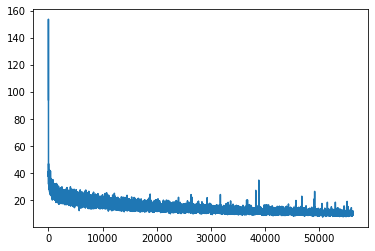

epoch: 31 	 step:0 	 loss: 10.78
epoch: 31 	 step:100 	 loss: 9.569
epoch: 31 	 step:200 	 loss: 9.395
epoch: 31 	 step:300 	 loss: 10.68
epoch: 31 	 step:400 	 loss: 9.881
epoch: 31 	 step:500 	 loss: 9.167
epoch: 31 	 step:600 	 loss: 10.85
epoch: 31 	 step:700 	 loss: 9.548
epoch: 31 	 step:800 	 loss: 8.894
epoch: 31 	 step:900 	 loss: 9.219
epoch: 31 	 step:1000 	 loss: 9.265
epoch: 31 	 step:1100 	 loss: 9.541
epoch: 31 	 step:1200 	 loss: 9.174
epoch: 31 	 step:1300 	 loss: 11.28
epoch: 31 	 step:1400 	 loss: 10.76
epoch: 31 	 step:1500 	 loss: 10.21
epoch: 31 	 step:1600 	 loss: 11.25
epoch: 31 	 step:1700 	 loss: 10.26
epoch: 31 	 step:1800 	 loss: 9.09


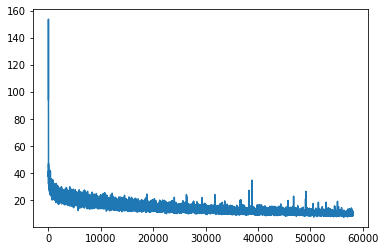

epoch: 32 	 step:0 	 loss: 9.436
epoch: 32 	 step:100 	 loss: 10.11
epoch: 32 	 step:200 	 loss: 10.12
epoch: 32 	 step:300 	 loss: 9.541
epoch: 32 	 step:400 	 loss: 9.244
epoch: 32 	 step:500 	 loss: 9.071
epoch: 32 	 step:600 	 loss: 9.884
epoch: 32 	 step:700 	 loss: 9.267
epoch: 32 	 step:800 	 loss: 10.75
epoch: 32 	 step:900 	 loss: 10.99
epoch: 32 	 step:1000 	 loss: 9.904
epoch: 32 	 step:1100 	 loss: 9.134
epoch: 32 	 step:1200 	 loss: 9.794
epoch: 32 	 step:1300 	 loss: 10.53
epoch: 32 	 step:1400 	 loss: 8.948
epoch: 32 	 step:1500 	 loss: 10.54
epoch: 32 	 step:1600 	 loss: 9.808
epoch: 32 	 step:1700 	 loss: 9.525
epoch: 32 	 step:1800 	 loss: 10.19


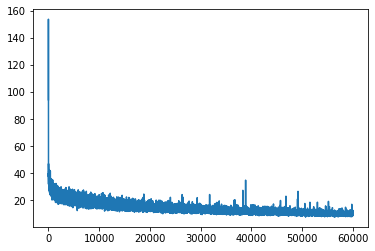

epoch: 33 	 step:0 	 loss: 9.243
epoch: 33 	 step:100 	 loss: 10.14
epoch: 33 	 step:200 	 loss: 9.05
epoch: 33 	 step:300 	 loss: 9.234
epoch: 33 	 step:400 	 loss: 10.4
epoch: 33 	 step:500 	 loss: 9.698
epoch: 33 	 step:600 	 loss: 9.753
epoch: 33 	 step:700 	 loss: 10.37
epoch: 33 	 step:800 	 loss: 8.927
epoch: 33 	 step:900 	 loss: 10.31
epoch: 33 	 step:1000 	 loss: 9.655
epoch: 33 	 step:1100 	 loss: 10.24
epoch: 33 	 step:1200 	 loss: 9.224
epoch: 33 	 step:1300 	 loss: 10.69
epoch: 33 	 step:1400 	 loss: 10.08
epoch: 33 	 step:1500 	 loss: 10.11
epoch: 33 	 step:1600 	 loss: 9.211
epoch: 33 	 step:1700 	 loss: 9.594
epoch: 33 	 step:1800 	 loss: 8.664


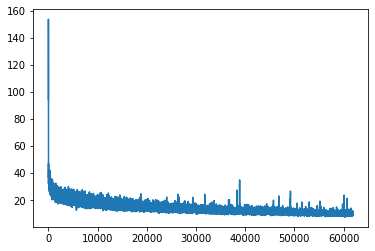

epoch: 34 	 step:0 	 loss: 9.416
epoch: 34 	 step:100 	 loss: 8.395
epoch: 34 	 step:200 	 loss: 9.464
epoch: 34 	 step:300 	 loss: 8.347
epoch: 34 	 step:400 	 loss: 10.3
epoch: 34 	 step:500 	 loss: 9.105
epoch: 34 	 step:600 	 loss: 10.93
epoch: 34 	 step:700 	 loss: 10.6
epoch: 34 	 step:800 	 loss: 9.044
epoch: 34 	 step:900 	 loss: 9.437
epoch: 34 	 step:1000 	 loss: 9.333
epoch: 34 	 step:1100 	 loss: 10.38
epoch: 34 	 step:1200 	 loss: 9.959
epoch: 34 	 step:1300 	 loss: 10.11
epoch: 34 	 step:1400 	 loss: 9.377
epoch: 34 	 step:1500 	 loss: 10.08
epoch: 34 	 step:1600 	 loss: 10.09
epoch: 34 	 step:1700 	 loss: 10.07
epoch: 34 	 step:1800 	 loss: 9.528


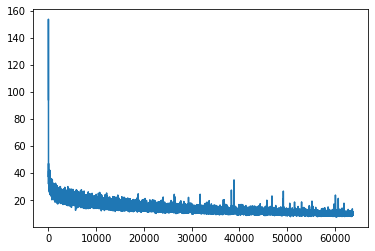

epoch: 35 	 step:0 	 loss: 9.217
epoch: 35 	 step:100 	 loss: 8.252
epoch: 35 	 step:200 	 loss: 9.665
epoch: 35 	 step:300 	 loss: 9.816
epoch: 35 	 step:400 	 loss: 8.981
epoch: 35 	 step:500 	 loss: 9.38
epoch: 35 	 step:600 	 loss: 9.447
epoch: 35 	 step:700 	 loss: 10.48
epoch: 35 	 step:800 	 loss: 8.782
epoch: 35 	 step:900 	 loss: 9.761
epoch: 35 	 step:1000 	 loss: 8.517
epoch: 35 	 step:1100 	 loss: 9.736
epoch: 35 	 step:1200 	 loss: 10.37
epoch: 35 	 step:1300 	 loss: 9.362
epoch: 35 	 step:1400 	 loss: 9.236
epoch: 35 	 step:1500 	 loss: 8.771
epoch: 35 	 step:1600 	 loss: 8.742
epoch: 35 	 step:1700 	 loss: 9.53
epoch: 35 	 step:1800 	 loss: 9.395


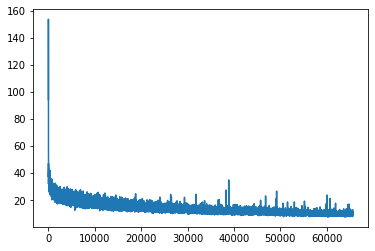

epoch: 36 	 step:0 	 loss: 8.751
epoch: 36 	 step:100 	 loss: 8.911
epoch: 36 	 step:200 	 loss: 8.744
epoch: 36 	 step:300 	 loss: 10.54
epoch: 36 	 step:400 	 loss: 9.261
epoch: 36 	 step:500 	 loss: 9.866
epoch: 36 	 step:600 	 loss: 9.26
epoch: 36 	 step:700 	 loss: 9.285
epoch: 36 	 step:800 	 loss: 9.927
epoch: 36 	 step:900 	 loss: 10.2
epoch: 36 	 step:1000 	 loss: 9.895
epoch: 36 	 step:1100 	 loss: 10.25
epoch: 36 	 step:1200 	 loss: 10.19
epoch: 36 	 step:1300 	 loss: 8.057
epoch: 36 	 step:1400 	 loss: 10.12
epoch: 36 	 step:1500 	 loss: 9.69
epoch: 36 	 step:1600 	 loss: 11.15
epoch: 36 	 step:1700 	 loss: 9.183
epoch: 36 	 step:1800 	 loss: 9.501


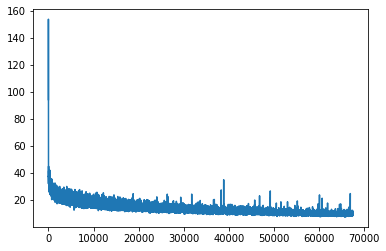

epoch: 37 	 step:0 	 loss: 8.234
epoch: 37 	 step:100 	 loss: 8.332
epoch: 37 	 step:200 	 loss: 9.273
epoch: 37 	 step:300 	 loss: 8.273
epoch: 37 	 step:400 	 loss: 9.021
epoch: 37 	 step:500 	 loss: 9.689
epoch: 37 	 step:600 	 loss: 8.463
epoch: 37 	 step:700 	 loss: 9.103
epoch: 37 	 step:800 	 loss: 9.059
epoch: 37 	 step:900 	 loss: 9.492
epoch: 37 	 step:1000 	 loss: 10.17
epoch: 37 	 step:1100 	 loss: 10.43
epoch: 37 	 step:1200 	 loss: 10.25
epoch: 37 	 step:1300 	 loss: 8.776
epoch: 37 	 step:1400 	 loss: 9.198
epoch: 37 	 step:1500 	 loss: 12.32
epoch: 37 	 step:1600 	 loss: 9.413
epoch: 37 	 step:1700 	 loss: 9.267
epoch: 37 	 step:1800 	 loss: 7.822


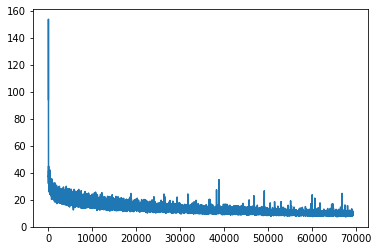

epoch: 38 	 step:0 	 loss: 9.178
epoch: 38 	 step:100 	 loss: 11.1
epoch: 38 	 step:200 	 loss: 9.395
epoch: 38 	 step:300 	 loss: 8.408
epoch: 38 	 step:400 	 loss: 9.457
epoch: 38 	 step:500 	 loss: 8.026
epoch: 38 	 step:600 	 loss: 9.646
epoch: 38 	 step:700 	 loss: 8.296
epoch: 38 	 step:800 	 loss: 8.36
epoch: 38 	 step:900 	 loss: 9.14
epoch: 38 	 step:1000 	 loss: 10.39
epoch: 38 	 step:1100 	 loss: 8.758
epoch: 38 	 step:1200 	 loss: 8.441
epoch: 38 	 step:1300 	 loss: 9.186
epoch: 38 	 step:1400 	 loss: 9.472
epoch: 38 	 step:1500 	 loss: 10.17
epoch: 38 	 step:1600 	 loss: 9.405
epoch: 38 	 step:1700 	 loss: 10.23
epoch: 38 	 step:1800 	 loss: 8.933


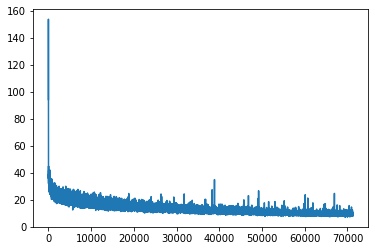

epoch: 39 	 step:0 	 loss: 8.051
epoch: 39 	 step:100 	 loss: 9.892
epoch: 39 	 step:200 	 loss: 9.026
epoch: 39 	 step:300 	 loss: 8.043
epoch: 39 	 step:400 	 loss: 9.658
epoch: 39 	 step:500 	 loss: 9.034
epoch: 39 	 step:600 	 loss: 8.664
epoch: 39 	 step:700 	 loss: 9.119
epoch: 39 	 step:800 	 loss: 8.897
epoch: 39 	 step:900 	 loss: 8.351
epoch: 39 	 step:1000 	 loss: 9.245
epoch: 39 	 step:1100 	 loss: 8.757
epoch: 39 	 step:1200 	 loss: 10.94
epoch: 39 	 step:1300 	 loss: 8.306
epoch: 39 	 step:1400 	 loss: 8.398
epoch: 39 	 step:1500 	 loss: 9.435
epoch: 39 	 step:1600 	 loss: 9.344
epoch: 39 	 step:1700 	 loss: 8.155
epoch: 39 	 step:1800 	 loss: 8.402


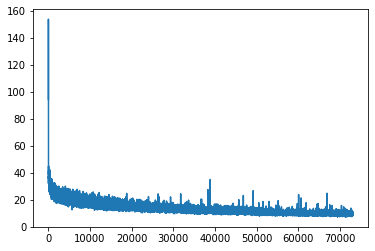

epoch: 40 	 step:0 	 loss: 9.288
epoch: 40 	 step:100 	 loss: 8.266
epoch: 40 	 step:200 	 loss: 8.076
epoch: 40 	 step:300 	 loss: 9.833
epoch: 40 	 step:400 	 loss: 8.547
epoch: 40 	 step:500 	 loss: 8.306
epoch: 40 	 step:600 	 loss: 8.454
epoch: 40 	 step:700 	 loss: 10.45
epoch: 40 	 step:800 	 loss: 8.43
epoch: 40 	 step:900 	 loss: 8.558
epoch: 40 	 step:1000 	 loss: 9.621
epoch: 40 	 step:1100 	 loss: 7.759
epoch: 40 	 step:1200 	 loss: 8.833
epoch: 40 	 step:1300 	 loss: 8.992
epoch: 40 	 step:1400 	 loss: 8.165
epoch: 40 	 step:1500 	 loss: 10.14
epoch: 40 	 step:1600 	 loss: 8.822
epoch: 40 	 step:1700 	 loss: 9.828
epoch: 40 	 step:1800 	 loss: 9.248


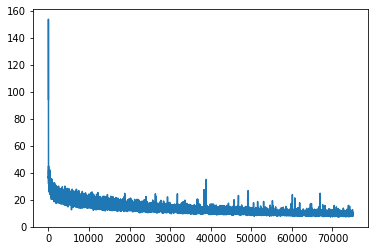

epoch: 41 	 step:0 	 loss: 8.646
epoch: 41 	 step:100 	 loss: 8.023
epoch: 41 	 step:200 	 loss: 9.796
epoch: 41 	 step:300 	 loss: 8.497
epoch: 41 	 step:400 	 loss: 9.663
epoch: 41 	 step:500 	 loss: 9.477
epoch: 41 	 step:600 	 loss: 8.069
epoch: 41 	 step:700 	 loss: 10.4
epoch: 41 	 step:800 	 loss: 8.443
epoch: 41 	 step:900 	 loss: 10.82
epoch: 41 	 step:1000 	 loss: 7.886
epoch: 41 	 step:1100 	 loss: 9.26
epoch: 41 	 step:1200 	 loss: 10.99
epoch: 41 	 step:1300 	 loss: 8.582
epoch: 41 	 step:1400 	 loss: 9.397
epoch: 41 	 step:1500 	 loss: 9.251
epoch: 41 	 step:1600 	 loss: 7.949
epoch: 41 	 step:1700 	 loss: 8.188
epoch: 41 	 step:1800 	 loss: 8.496


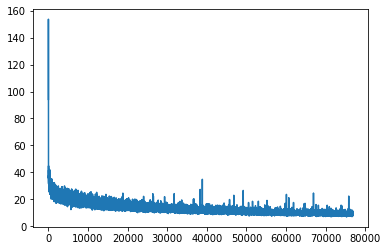

epoch: 42 	 step:0 	 loss: 8.659
epoch: 42 	 step:100 	 loss: 9.17
epoch: 42 	 step:200 	 loss: 7.881
epoch: 42 	 step:300 	 loss: 8.097
epoch: 42 	 step:400 	 loss: 7.508
epoch: 42 	 step:500 	 loss: 8.34
epoch: 42 	 step:600 	 loss: 7.952
epoch: 42 	 step:700 	 loss: 8.738
epoch: 42 	 step:800 	 loss: 8.114
epoch: 42 	 step:900 	 loss: 10.13
epoch: 42 	 step:1000 	 loss: 10.13
epoch: 42 	 step:1100 	 loss: 9.415
epoch: 42 	 step:1200 	 loss: 7.64
epoch: 42 	 step:1300 	 loss: 8.931
epoch: 42 	 step:1400 	 loss: 8.729
epoch: 42 	 step:1500 	 loss: 8.917
epoch: 42 	 step:1600 	 loss: 8.585
epoch: 42 	 step:1700 	 loss: 8.9
epoch: 42 	 step:1800 	 loss: 8.449


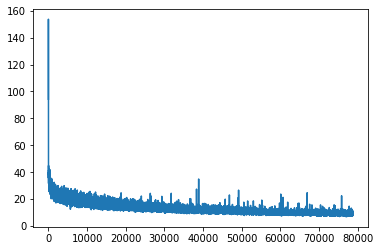

epoch: 43 	 step:0 	 loss: 7.916
epoch: 43 	 step:100 	 loss: 7.881
epoch: 43 	 step:200 	 loss: 7.762
epoch: 43 	 step:300 	 loss: 8.149
epoch: 43 	 step:400 	 loss: 8.303
epoch: 43 	 step:500 	 loss: 8.656
epoch: 43 	 step:600 	 loss: 9.199
epoch: 43 	 step:700 	 loss: 9.212
epoch: 43 	 step:800 	 loss: 7.928
epoch: 43 	 step:900 	 loss: 9.606
epoch: 43 	 step:1000 	 loss: 8.487
epoch: 43 	 step:1100 	 loss: 8.628
epoch: 43 	 step:1200 	 loss: 8.334
epoch: 43 	 step:1300 	 loss: 8.807
epoch: 43 	 step:1400 	 loss: 8.53
epoch: 43 	 step:1500 	 loss: 9.37
epoch: 43 	 step:1600 	 loss: 10.41
epoch: 43 	 step:1700 	 loss: 8.343
epoch: 43 	 step:1800 	 loss: 11.33


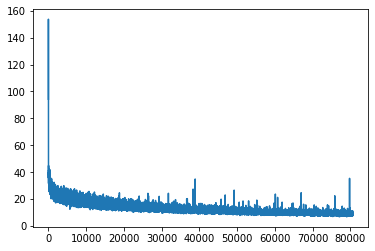

epoch: 44 	 step:0 	 loss: 8.758
epoch: 44 	 step:100 	 loss: 9.167
epoch: 44 	 step:200 	 loss: 8.966
epoch: 44 	 step:300 	 loss: 8.15
epoch: 44 	 step:400 	 loss: 8.202
epoch: 44 	 step:500 	 loss: 8.18
epoch: 44 	 step:600 	 loss: 8.945
epoch: 44 	 step:700 	 loss: 9.121
epoch: 44 	 step:800 	 loss: 9.734
epoch: 44 	 step:900 	 loss: 9.446
epoch: 44 	 step:1000 	 loss: 8.402
epoch: 44 	 step:1100 	 loss: 9.356
epoch: 44 	 step:1200 	 loss: 8.817
epoch: 44 	 step:1300 	 loss: 7.536
epoch: 44 	 step:1400 	 loss: 9.509
epoch: 44 	 step:1500 	 loss: 8.435
epoch: 44 	 step:1600 	 loss: 8.977
epoch: 44 	 step:1700 	 loss: 8.218
epoch: 44 	 step:1800 	 loss: 8.282


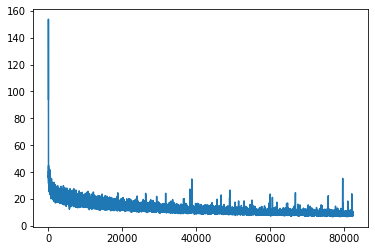

epoch: 45 	 step:0 	 loss: 8.803
epoch: 45 	 step:100 	 loss: 8.725
epoch: 45 	 step:200 	 loss: 7.372
epoch: 45 	 step:300 	 loss: 7.834
epoch: 45 	 step:400 	 loss: 9.426
epoch: 45 	 step:500 	 loss: 8.083
epoch: 45 	 step:600 	 loss: 7.919
epoch: 45 	 step:700 	 loss: 8.038
epoch: 45 	 step:800 	 loss: 8.311
epoch: 45 	 step:900 	 loss: 8.252
epoch: 45 	 step:1000 	 loss: 8.084
epoch: 45 	 step:1100 	 loss: 8.742
epoch: 45 	 step:1200 	 loss: 8.696
epoch: 45 	 step:1300 	 loss: 8.256
epoch: 45 	 step:1400 	 loss: 8.74
epoch: 45 	 step:1500 	 loss: 8.532
epoch: 45 	 step:1600 	 loss: 8.876
epoch: 45 	 step:1700 	 loss: 9.119
epoch: 45 	 step:1800 	 loss: 8.366


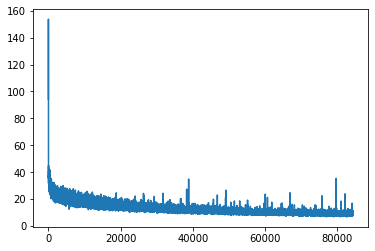

epoch: 46 	 step:0 	 loss: 7.9
epoch: 46 	 step:100 	 loss: 8.741
epoch: 46 	 step:200 	 loss: 9.25
epoch: 46 	 step:300 	 loss: 9.27
epoch: 46 	 step:400 	 loss: 8.499
epoch: 46 	 step:500 	 loss: 7.421
epoch: 46 	 step:600 	 loss: 8.549
epoch: 46 	 step:700 	 loss: 8.411
epoch: 46 	 step:800 	 loss: 8.759
epoch: 46 	 step:900 	 loss: 7.737
epoch: 46 	 step:1000 	 loss: 9.081
epoch: 46 	 step:1100 	 loss: 9.625
epoch: 46 	 step:1200 	 loss: 8.391
epoch: 46 	 step:1300 	 loss: 9.181
epoch: 46 	 step:1400 	 loss: 9.718
epoch: 46 	 step:1500 	 loss: 9.621
epoch: 46 	 step:1600 	 loss: 8.622
epoch: 46 	 step:1700 	 loss: 10.49
epoch: 46 	 step:1800 	 loss: 7.993


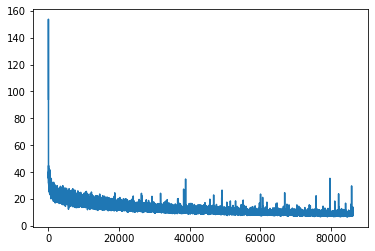

epoch: 47 	 step:0 	 loss: 7.948
epoch: 47 	 step:100 	 loss: 8.239
epoch: 47 	 step:200 	 loss: 8.477
epoch: 47 	 step:300 	 loss: 9.409
epoch: 47 	 step:400 	 loss: 6.995
epoch: 47 	 step:500 	 loss: 8.012
epoch: 47 	 step:600 	 loss: 8.196
epoch: 47 	 step:700 	 loss: 8.213
epoch: 47 	 step:800 	 loss: 8.432
epoch: 47 	 step:900 	 loss: 9.1
epoch: 47 	 step:1000 	 loss: 8.866
epoch: 47 	 step:1100 	 loss: 8.402
epoch: 47 	 step:1200 	 loss: 7.952
epoch: 47 	 step:1300 	 loss: 7.317
epoch: 47 	 step:1400 	 loss: 7.789
epoch: 47 	 step:1500 	 loss: 8.539
epoch: 47 	 step:1600 	 loss: 8.079
epoch: 47 	 step:1700 	 loss: 7.852
epoch: 47 	 step:1800 	 loss: 8.818


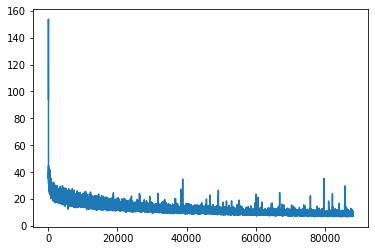

epoch: 48 	 step:0 	 loss: 8.921
epoch: 48 	 step:100 	 loss: 7.494
epoch: 48 	 step:200 	 loss: 8.431
epoch: 48 	 step:300 	 loss: 8.187
epoch: 48 	 step:400 	 loss: 8.27
epoch: 48 	 step:500 	 loss: 8.651
epoch: 48 	 step:600 	 loss: 8.292
epoch: 48 	 step:700 	 loss: 7.786
epoch: 48 	 step:800 	 loss: 9.156
epoch: 48 	 step:900 	 loss: 8.445
epoch: 48 	 step:1000 	 loss: 8.119
epoch: 48 	 step:1100 	 loss: 8.735
epoch: 48 	 step:1200 	 loss: 7.968
epoch: 48 	 step:1300 	 loss: 7.904
epoch: 48 	 step:1400 	 loss: 8.452
epoch: 48 	 step:1500 	 loss: 8.913
epoch: 48 	 step:1600 	 loss: 8.322
epoch: 48 	 step:1700 	 loss: 8.322
epoch: 48 	 step:1800 	 loss: 9.566


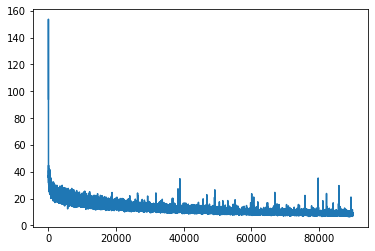

epoch: 49 	 step:0 	 loss: 8.114
epoch: 49 	 step:100 	 loss: 8.235
epoch: 49 	 step:200 	 loss: 7.626
epoch: 49 	 step:300 	 loss: 8.277
epoch: 49 	 step:400 	 loss: 7.408
epoch: 49 	 step:500 	 loss: 7.461
epoch: 49 	 step:600 	 loss: 8.271
epoch: 49 	 step:700 	 loss: 7.712
epoch: 49 	 step:800 	 loss: 9.6
epoch: 49 	 step:900 	 loss: 8.479
epoch: 49 	 step:1000 	 loss: 7.434
epoch: 49 	 step:1100 	 loss: 7.585
epoch: 49 	 step:1200 	 loss: 7.959
epoch: 49 	 step:1300 	 loss: 8.828
epoch: 49 	 step:1400 	 loss: 8.286
epoch: 49 	 step:1500 	 loss: 8.212
epoch: 49 	 step:1600 	 loss: 7.38
epoch: 49 	 step:1700 	 loss: 8.395
epoch: 49 	 step:1800 	 loss: 7.822


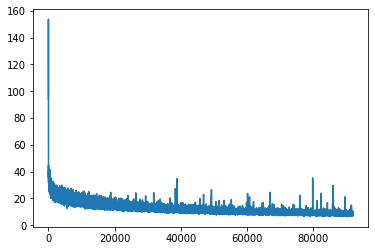

epoch: 50 	 step:0 	 loss: 8.413
epoch: 50 	 step:100 	 loss: 8.473
epoch: 50 	 step:200 	 loss: 7.9
epoch: 50 	 step:300 	 loss: 8.019
epoch: 50 	 step:400 	 loss: 8.038
epoch: 50 	 step:500 	 loss: 8.138
epoch: 50 	 step:600 	 loss: 8.596
epoch: 50 	 step:700 	 loss: 8.212
epoch: 50 	 step:800 	 loss: 9.265
epoch: 50 	 step:900 	 loss: 7.852
epoch: 50 	 step:1000 	 loss: 8.315
epoch: 50 	 step:1100 	 loss: 8.123
epoch: 50 	 step:1200 	 loss: 7.55
epoch: 50 	 step:1300 	 loss: 7.826
epoch: 50 	 step:1400 	 loss: 8.703
epoch: 50 	 step:1500 	 loss: 8.966
epoch: 50 	 step:1600 	 loss: 8.596
epoch: 50 	 step:1700 	 loss: 8.392
epoch: 50 	 step:1800 	 loss: 8.212


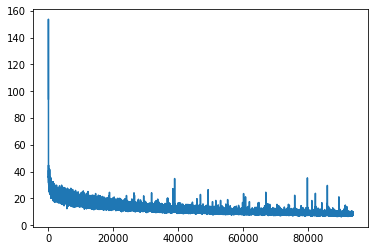

epoch: 51 	 step:0 	 loss: 8.071
epoch: 51 	 step:100 	 loss: 8.343
epoch: 51 	 step:200 	 loss: 8.327
epoch: 51 	 step:300 	 loss: 8.422
epoch: 51 	 step:400 	 loss: 9.902
epoch: 51 	 step:500 	 loss: 7.872
epoch: 51 	 step:600 	 loss: 7.855
epoch: 51 	 step:700 	 loss: 7.038
epoch: 51 	 step:800 	 loss: 7.778
epoch: 51 	 step:900 	 loss: 8.065
epoch: 51 	 step:1000 	 loss: 8.052
epoch: 51 	 step:1100 	 loss: 7.07
epoch: 51 	 step:1200 	 loss: 7.496
epoch: 51 	 step:1300 	 loss: 8.039
epoch: 51 	 step:1400 	 loss: 7.8
epoch: 51 	 step:1500 	 loss: 9.242
epoch: 51 	 step:1600 	 loss: 9.447
epoch: 51 	 step:1700 	 loss: 8.846
epoch: 51 	 step:1800 	 loss: 8.652


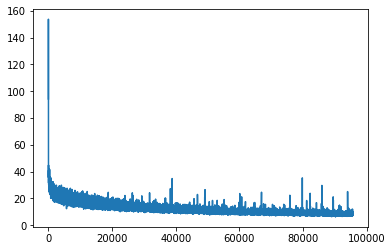

epoch: 52 	 step:0 	 loss: 7.881
epoch: 52 	 step:100 	 loss: 8.159
epoch: 52 	 step:200 	 loss: 7.263
epoch: 52 	 step:300 	 loss: 8.044
epoch: 52 	 step:400 	 loss: 8.626
epoch: 52 	 step:500 	 loss: 6.879
epoch: 52 	 step:600 	 loss: 7.466
epoch: 52 	 step:700 	 loss: 8.646
epoch: 52 	 step:800 	 loss: 7.591
epoch: 52 	 step:900 	 loss: 7.731
epoch: 52 	 step:1000 	 loss: 8.714
epoch: 52 	 step:1100 	 loss: 7.388
epoch: 52 	 step:1200 	 loss: 8.49
epoch: 52 	 step:1300 	 loss: 8.165
epoch: 52 	 step:1400 	 loss: 8.208
epoch: 52 	 step:1500 	 loss: 8.694
epoch: 52 	 step:1600 	 loss: 7.834
epoch: 52 	 step:1700 	 loss: 7.897
epoch: 52 	 step:1800 	 loss: 8.146


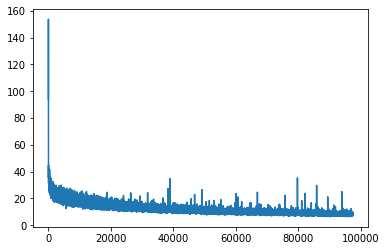

epoch: 53 	 step:0 	 loss: 7.31
epoch: 53 	 step:100 	 loss: 8.078
epoch: 53 	 step:200 	 loss: 7.352
epoch: 53 	 step:300 	 loss: 7.116
epoch: 53 	 step:400 	 loss: 8.161
epoch: 53 	 step:500 	 loss: 7.238
epoch: 53 	 step:600 	 loss: 7.143
epoch: 53 	 step:700 	 loss: 9.213
epoch: 53 	 step:800 	 loss: 7.609
epoch: 53 	 step:900 	 loss: 8.389
epoch: 53 	 step:1000 	 loss: 7.568
epoch: 53 	 step:1100 	 loss: 6.855
epoch: 53 	 step:1200 	 loss: 7.466
epoch: 53 	 step:1300 	 loss: 8.839
epoch: 53 	 step:1400 	 loss: 7.587
epoch: 53 	 step:1500 	 loss: 7.922
epoch: 53 	 step:1600 	 loss: 9.112
epoch: 53 	 step:1700 	 loss: 8.932
epoch: 53 	 step:1800 	 loss: 8.914


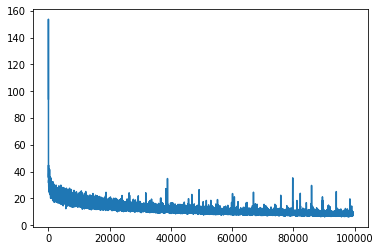

epoch: 54 	 step:0 	 loss: 7.904
epoch: 54 	 step:100 	 loss: 7.708
epoch: 54 	 step:200 	 loss: 7.539
epoch: 54 	 step:300 	 loss: 8.37
epoch: 54 	 step:400 	 loss: 8.134
epoch: 54 	 step:500 	 loss: 7.585
epoch: 54 	 step:600 	 loss: 8.236
epoch: 54 	 step:700 	 loss: 8.024
epoch: 54 	 step:800 	 loss: 7.547
epoch: 54 	 step:900 	 loss: 8.305
epoch: 54 	 step:1000 	 loss: 7.15
epoch: 54 	 step:1100 	 loss: 8.207
epoch: 54 	 step:1200 	 loss: 7.351
epoch: 54 	 step:1300 	 loss: 9.315
epoch: 54 	 step:1400 	 loss: 7.787
epoch: 54 	 step:1500 	 loss: 8.249
epoch: 54 	 step:1600 	 loss: 7.448
epoch: 54 	 step:1700 	 loss: 8.159
epoch: 54 	 step:1800 	 loss: 7.587


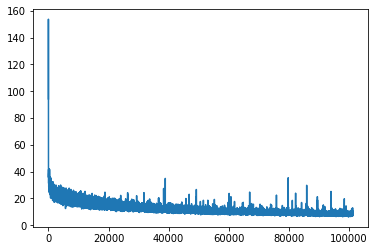

epoch: 55 	 step:0 	 loss: 7.437
epoch: 55 	 step:100 	 loss: 6.956
epoch: 55 	 step:200 	 loss: 7.591
epoch: 55 	 step:300 	 loss: 7.572
epoch: 55 	 step:400 	 loss: 7.479
epoch: 55 	 step:500 	 loss: 7.023
epoch: 55 	 step:600 	 loss: 7.303
epoch: 55 	 step:700 	 loss: 7.821
epoch: 55 	 step:800 	 loss: 8.277
epoch: 55 	 step:900 	 loss: 7.956
epoch: 55 	 step:1000 	 loss: 7.75
epoch: 55 	 step:1100 	 loss: 7.816
epoch: 55 	 step:1200 	 loss: 8.092
epoch: 55 	 step:1300 	 loss: 7.592
epoch: 55 	 step:1400 	 loss: 8.569
epoch: 55 	 step:1500 	 loss: 8.691
epoch: 55 	 step:1600 	 loss: 7.807
epoch: 55 	 step:1700 	 loss: 8.313
epoch: 55 	 step:1800 	 loss: 7.63


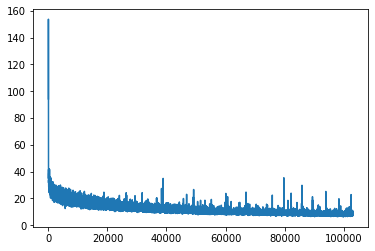

epoch: 56 	 step:0 	 loss: 7.683
epoch: 56 	 step:100 	 loss: 7.974
epoch: 56 	 step:200 	 loss: 7.363
epoch: 56 	 step:300 	 loss: 7.914
epoch: 56 	 step:400 	 loss: 7.394
epoch: 56 	 step:500 	 loss: 7.92
epoch: 56 	 step:600 	 loss: 7.211
epoch: 56 	 step:700 	 loss: 8.027
epoch: 56 	 step:800 	 loss: 7.964
epoch: 56 	 step:900 	 loss: 7.697
epoch: 56 	 step:1000 	 loss: 8.731
epoch: 56 	 step:1100 	 loss: 7.967
epoch: 56 	 step:1200 	 loss: 8.612
epoch: 56 	 step:1300 	 loss: 7.952
epoch: 56 	 step:1400 	 loss: 8.392
epoch: 56 	 step:1500 	 loss: 8.567
epoch: 56 	 step:1600 	 loss: 7.376
epoch: 56 	 step:1700 	 loss: 7.503
epoch: 56 	 step:1800 	 loss: 7.792


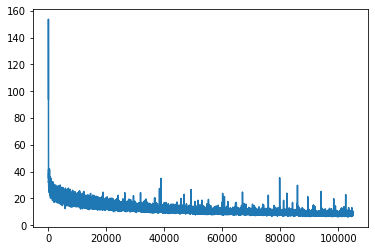

epoch: 57 	 step:0 	 loss: 7.329
epoch: 57 	 step:100 	 loss: 7.579
epoch: 57 	 step:200 	 loss: 7.398
epoch: 57 	 step:300 	 loss: 7.471
epoch: 57 	 step:400 	 loss: 7.459
epoch: 57 	 step:500 	 loss: 7.493
epoch: 57 	 step:600 	 loss: 7.857
epoch: 57 	 step:700 	 loss: 7.325
epoch: 57 	 step:800 	 loss: 7.041
epoch: 57 	 step:900 	 loss: 7.371
epoch: 57 	 step:1000 	 loss: 7.131
epoch: 57 	 step:1100 	 loss: 7.655
epoch: 57 	 step:1200 	 loss: 7.973
epoch: 57 	 step:1300 	 loss: 7.963
epoch: 57 	 step:1400 	 loss: 7.427
epoch: 57 	 step:1500 	 loss: 7.736
epoch: 57 	 step:1600 	 loss: 8.031
epoch: 57 	 step:1700 	 loss: 7.984
epoch: 57 	 step:1800 	 loss: 7.977


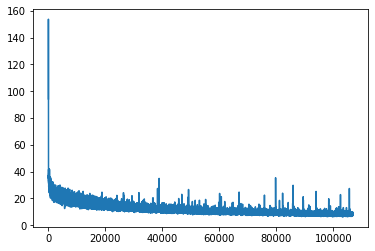

epoch: 58 	 step:0 	 loss: 7.722
epoch: 58 	 step:100 	 loss: 8.02
epoch: 58 	 step:200 	 loss: 7.17
epoch: 58 	 step:300 	 loss: 7.682
epoch: 58 	 step:400 	 loss: 7.539
epoch: 58 	 step:500 	 loss: 7.604
epoch: 58 	 step:600 	 loss: 7.233
epoch: 58 	 step:700 	 loss: 7.983
epoch: 58 	 step:800 	 loss: 8.028
epoch: 58 	 step:900 	 loss: 8.216
epoch: 58 	 step:1000 	 loss: 8.006
epoch: 58 	 step:1100 	 loss: 9.478
epoch: 58 	 step:1200 	 loss: 7.432
epoch: 58 	 step:1300 	 loss: 8.002
epoch: 58 	 step:1400 	 loss: 7.611
epoch: 58 	 step:1500 	 loss: 7.624
epoch: 58 	 step:1600 	 loss: 7.571
epoch: 58 	 step:1700 	 loss: 7.862
epoch: 58 	 step:1800 	 loss: 8.44


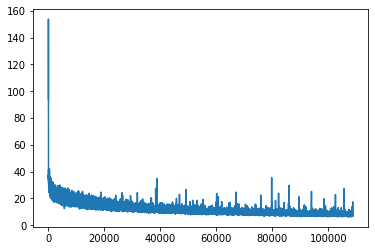

epoch: 59 	 step:0 	 loss: 8.206
epoch: 59 	 step:100 	 loss: 7.623
epoch: 59 	 step:200 	 loss: 7.46
epoch: 59 	 step:300 	 loss: 7.911
epoch: 59 	 step:400 	 loss: 7.489
epoch: 59 	 step:500 	 loss: 7.663
epoch: 59 	 step:600 	 loss: 8.13
epoch: 59 	 step:700 	 loss: 7.266
epoch: 59 	 step:800 	 loss: 8.378
epoch: 59 	 step:900 	 loss: 8.152
epoch: 59 	 step:1000 	 loss: 7.753
epoch: 59 	 step:1100 	 loss: 7.639
epoch: 59 	 step:1200 	 loss: 6.887
epoch: 59 	 step:1300 	 loss: 7.823
epoch: 59 	 step:1400 	 loss: 8.847
epoch: 59 	 step:1500 	 loss: 8.641
epoch: 59 	 step:1600 	 loss: 8.581
epoch: 59 	 step:1700 	 loss: 7.763
epoch: 59 	 step:1800 	 loss: 9.272


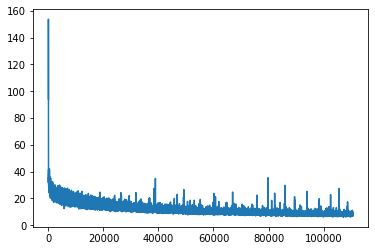

epoch: 60 	 step:0 	 loss: 8.111
epoch: 60 	 step:100 	 loss: 8.913
epoch: 60 	 step:200 	 loss: 6.776
epoch: 60 	 step:300 	 loss: 7.707
epoch: 60 	 step:400 	 loss: 7.526
epoch: 60 	 step:500 	 loss: 7.024
epoch: 60 	 step:600 	 loss: 8.286
epoch: 60 	 step:700 	 loss: 8.022
epoch: 60 	 step:800 	 loss: 7.528
epoch: 60 	 step:900 	 loss: 8.179
epoch: 60 	 step:1000 	 loss: 8.785
epoch: 60 	 step:1100 	 loss: 7.829
epoch: 60 	 step:1200 	 loss: 7.055
epoch: 60 	 step:1300 	 loss: 7.443
epoch: 60 	 step:1400 	 loss: 7.684
epoch: 60 	 step:1500 	 loss: 7.523
epoch: 60 	 step:1600 	 loss: 6.598
epoch: 60 	 step:1700 	 loss: 7.597
epoch: 60 	 step:1800 	 loss: 8.233


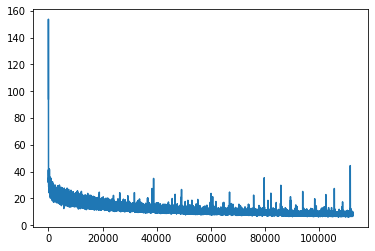

epoch: 61 	 step:0 	 loss: 7.028
epoch: 61 	 step:100 	 loss: 7.46
epoch: 61 	 step:200 	 loss: 8.224
epoch: 61 	 step:300 	 loss: 8.506
epoch: 61 	 step:400 	 loss: 7.389
epoch: 61 	 step:500 	 loss: 7.129
epoch: 61 	 step:600 	 loss: 7.724
epoch: 61 	 step:700 	 loss: 6.962
epoch: 61 	 step:800 	 loss: 7.74
epoch: 61 	 step:900 	 loss: 7.533
epoch: 61 	 step:1000 	 loss: 7.958
epoch: 61 	 step:1100 	 loss: 7.422
epoch: 61 	 step:1200 	 loss: 8.05
epoch: 61 	 step:1300 	 loss: 7.128
epoch: 61 	 step:1400 	 loss: 7.727
epoch: 61 	 step:1500 	 loss: 8.549
epoch: 61 	 step:1600 	 loss: 7.66
epoch: 61 	 step:1700 	 loss: 8.155
epoch: 61 	 step:1800 	 loss: 6.964


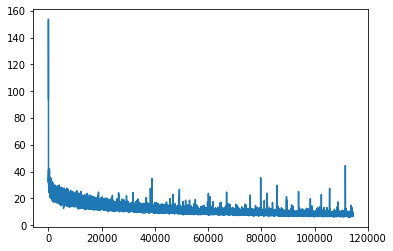

epoch: 62 	 step:0 	 loss: 7.19
epoch: 62 	 step:100 	 loss: 8.198
epoch: 62 	 step:200 	 loss: 7.086
epoch: 62 	 step:300 	 loss: 7.115
epoch: 62 	 step:400 	 loss: 7.561
epoch: 62 	 step:500 	 loss: 7.66
epoch: 62 	 step:600 	 loss: 6.982
epoch: 62 	 step:700 	 loss: 8.485
epoch: 62 	 step:800 	 loss: 7.13
epoch: 62 	 step:900 	 loss: 7.847
epoch: 62 	 step:1000 	 loss: 7.154
epoch: 62 	 step:1100 	 loss: 6.986
epoch: 62 	 step:1200 	 loss: 8.008
epoch: 62 	 step:1300 	 loss: 7.666
epoch: 62 	 step:1400 	 loss: 7.973
epoch: 62 	 step:1500 	 loss: 7.518
epoch: 62 	 step:1600 	 loss: 7.967
epoch: 62 	 step:1700 	 loss: 9.029
epoch: 62 	 step:1800 	 loss: 6.821


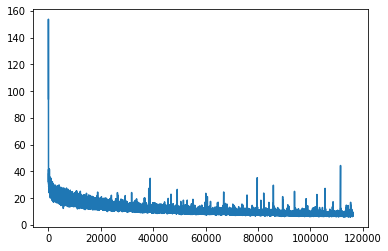

epoch: 63 	 step:0 	 loss: 7.242
epoch: 63 	 step:100 	 loss: 6.854
epoch: 63 	 step:200 	 loss: 7.768
epoch: 63 	 step:300 	 loss: 6.987
epoch: 63 	 step:400 	 loss: 7.786
epoch: 63 	 step:500 	 loss: 8.059
epoch: 63 	 step:600 	 loss: 7.008
epoch: 63 	 step:700 	 loss: 6.92
epoch: 63 	 step:800 	 loss: 7.732
epoch: 63 	 step:900 	 loss: 8.026
epoch: 63 	 step:1000 	 loss: 8.646
epoch: 63 	 step:1100 	 loss: 7.68
epoch: 63 	 step:1200 	 loss: 7.437
epoch: 63 	 step:1300 	 loss: 7.637
epoch: 63 	 step:1400 	 loss: 8.558
epoch: 63 	 step:1500 	 loss: 7.74
epoch: 63 	 step:1600 	 loss: 9.82
epoch: 63 	 step:1700 	 loss: 6.722
epoch: 63 	 step:1800 	 loss: 8.032


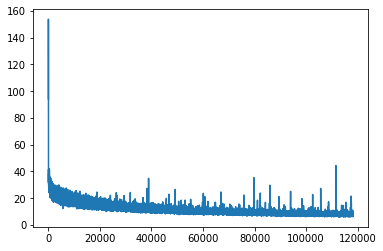

epoch: 64 	 step:0 	 loss: 7.593
epoch: 64 	 step:100 	 loss: 7.827
epoch: 64 	 step:200 	 loss: 7.612
epoch: 64 	 step:300 	 loss: 6.818
epoch: 64 	 step:400 	 loss: 7.264
epoch: 64 	 step:500 	 loss: 7.134
epoch: 64 	 step:600 	 loss: 7.699
epoch: 64 	 step:700 	 loss: 8.157
epoch: 64 	 step:800 	 loss: 8.242
epoch: 64 	 step:900 	 loss: 7.233
epoch: 64 	 step:1000 	 loss: 7.144
epoch: 64 	 step:1100 	 loss: 7.783
epoch: 64 	 step:1200 	 loss: 7.27
epoch: 64 	 step:1300 	 loss: 8.229
epoch: 64 	 step:1400 	 loss: 6.604
epoch: 64 	 step:1500 	 loss: 7.878
epoch: 64 	 step:1600 	 loss: 7.88
epoch: 64 	 step:1700 	 loss: 6.75
epoch: 64 	 step:1800 	 loss: 7.697


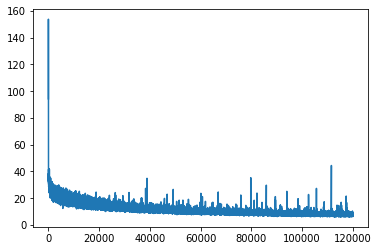

epoch: 65 	 step:0 	 loss: 6.658
epoch: 65 	 step:100 	 loss: 7.835
epoch: 65 	 step:200 	 loss: 7.164
epoch: 65 	 step:300 	 loss: 7.823
epoch: 65 	 step:400 	 loss: 7.053
epoch: 65 	 step:500 	 loss: 6.592
epoch: 65 	 step:600 	 loss: 7.47
epoch: 65 	 step:700 	 loss: 8.194
epoch: 65 	 step:800 	 loss: 7.379
epoch: 65 	 step:900 	 loss: 8.365
epoch: 65 	 step:1000 	 loss: 6.925
epoch: 65 	 step:1100 	 loss: 6.86
epoch: 65 	 step:1200 	 loss: 7.341
epoch: 65 	 step:1300 	 loss: 7.055
epoch: 65 	 step:1400 	 loss: 7.158
epoch: 65 	 step:1500 	 loss: 7.745
epoch: 65 	 step:1600 	 loss: 7.501
epoch: 65 	 step:1700 	 loss: 7.91
epoch: 65 	 step:1800 	 loss: 7.287


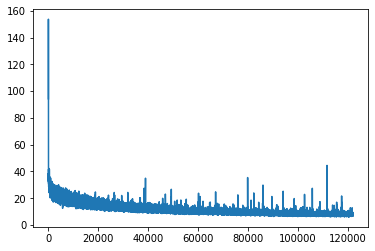

epoch: 66 	 step:0 	 loss: 7.142
epoch: 66 	 step:100 	 loss: 7.563
epoch: 66 	 step:200 	 loss: 6.926
epoch: 66 	 step:300 	 loss: 7.386
epoch: 66 	 step:400 	 loss: 7.623
epoch: 66 	 step:500 	 loss: 7.421
epoch: 66 	 step:600 	 loss: 8.611
epoch: 66 	 step:700 	 loss: 7.775
epoch: 66 	 step:800 	 loss: 7.779
epoch: 66 	 step:900 	 loss: 7.048
epoch: 66 	 step:1000 	 loss: 7.627
epoch: 66 	 step:1100 	 loss: 12.66
epoch: 66 	 step:1200 	 loss: 7.576
epoch: 66 	 step:1300 	 loss: 8.2
epoch: 66 	 step:1400 	 loss: 8.143
epoch: 66 	 step:1500 	 loss: 6.389
epoch: 66 	 step:1600 	 loss: 7.486
epoch: 66 	 step:1700 	 loss: 8.204
epoch: 66 	 step:1800 	 loss: 7.949


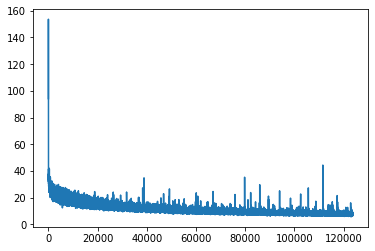

epoch: 67 	 step:0 	 loss: 7.218
epoch: 67 	 step:100 	 loss: 8.362
epoch: 67 	 step:200 	 loss: 6.587
epoch: 67 	 step:300 	 loss: 7.578
epoch: 67 	 step:400 	 loss: 6.956
epoch: 67 	 step:500 	 loss: 7.125
epoch: 67 	 step:600 	 loss: 6.575
epoch: 67 	 step:700 	 loss: 8.122
epoch: 67 	 step:800 	 loss: 7.018
epoch: 67 	 step:900 	 loss: 6.673
epoch: 67 	 step:1000 	 loss: 7.879
epoch: 67 	 step:1100 	 loss: 7.139
epoch: 67 	 step:1200 	 loss: 7.087
epoch: 67 	 step:1300 	 loss: 6.803
epoch: 67 	 step:1400 	 loss: 7.851
epoch: 67 	 step:1500 	 loss: 7.926
epoch: 67 	 step:1600 	 loss: 7.898
epoch: 67 	 step:1700 	 loss: 7.679
epoch: 67 	 step:1800 	 loss: 7.87


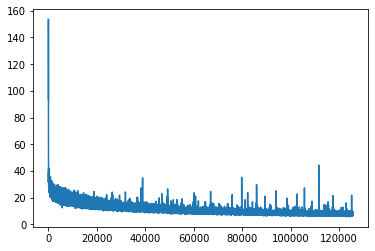

epoch: 68 	 step:0 	 loss: 6.833
epoch: 68 	 step:100 	 loss: 7.519
epoch: 68 	 step:200 	 loss: 7.517
epoch: 68 	 step:300 	 loss: 7.487
epoch: 68 	 step:400 	 loss: 8.084
epoch: 68 	 step:500 	 loss: 7.403
epoch: 68 	 step:600 	 loss: 6.74
epoch: 68 	 step:700 	 loss: 7.526
epoch: 68 	 step:800 	 loss: 6.986
epoch: 68 	 step:900 	 loss: 7.338
epoch: 68 	 step:1000 	 loss: 7.718
epoch: 68 	 step:1100 	 loss: 7.426
epoch: 68 	 step:1200 	 loss: 7.073
epoch: 68 	 step:1300 	 loss: 6.658
epoch: 68 	 step:1400 	 loss: 7.925
epoch: 68 	 step:1500 	 loss: 6.676
epoch: 68 	 step:1600 	 loss: 7.998
epoch: 68 	 step:1700 	 loss: 7.218
epoch: 68 	 step:1800 	 loss: 7.967


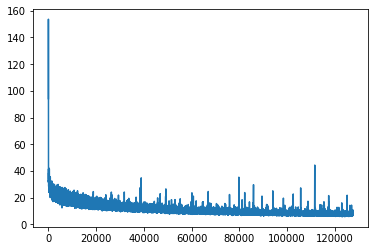

epoch: 69 	 step:0 	 loss: 7.118
epoch: 69 	 step:100 	 loss: 6.695
epoch: 69 	 step:200 	 loss: 7.233
epoch: 69 	 step:300 	 loss: 6.532
epoch: 69 	 step:400 	 loss: 6.904
epoch: 69 	 step:500 	 loss: 8.242
epoch: 69 	 step:600 	 loss: 6.628
epoch: 69 	 step:700 	 loss: 7.078
epoch: 69 	 step:800 	 loss: 7.382
epoch: 69 	 step:900 	 loss: 6.983
epoch: 69 	 step:1000 	 loss: 6.889
epoch: 69 	 step:1100 	 loss: 7.677
epoch: 69 	 step:1200 	 loss: 8.488
epoch: 69 	 step:1300 	 loss: 8.133
epoch: 69 	 step:1400 	 loss: 7.206
epoch: 69 	 step:1500 	 loss: 8.062
epoch: 69 	 step:1600 	 loss: 7.611
epoch: 69 	 step:1700 	 loss: 7.418
epoch: 69 	 step:1800 	 loss: 8.598


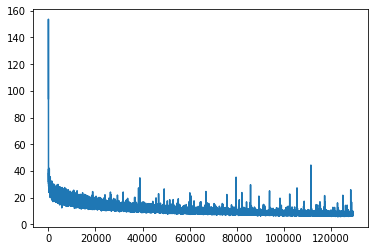

epoch: 70 	 step:0 	 loss: 7.367
epoch: 70 	 step:100 	 loss: 6.841
epoch: 70 	 step:200 	 loss: 7.609
epoch: 70 	 step:300 	 loss: 7.249
epoch: 70 	 step:400 	 loss: 6.527
epoch: 70 	 step:500 	 loss: 6.958
epoch: 70 	 step:600 	 loss: 7.495
epoch: 70 	 step:700 	 loss: 6.792
epoch: 70 	 step:800 	 loss: 6.364
epoch: 70 	 step:900 	 loss: 7.144
epoch: 70 	 step:1000 	 loss: 7.469
epoch: 70 	 step:1100 	 loss: 6.622
epoch: 70 	 step:1200 	 loss: 8.018
epoch: 70 	 step:1300 	 loss: 8.13
epoch: 70 	 step:1400 	 loss: 7.303
epoch: 70 	 step:1500 	 loss: 7.151
epoch: 70 	 step:1600 	 loss: 7.099
epoch: 70 	 step:1700 	 loss: 8.365
epoch: 70 	 step:1800 	 loss: 7.06


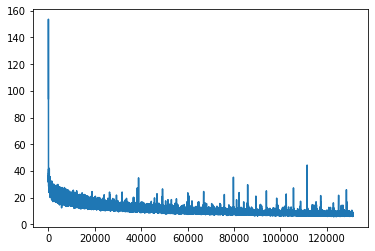

epoch: 71 	 step:0 	 loss: 6.876
epoch: 71 	 step:100 	 loss: 6.775
epoch: 71 	 step:200 	 loss: 6.588
epoch: 71 	 step:300 	 loss: 6.844
epoch: 71 	 step:400 	 loss: 7.434
epoch: 71 	 step:500 	 loss: 6.694
epoch: 71 	 step:600 	 loss: 5.992
epoch: 71 	 step:700 	 loss: 7.16
epoch: 71 	 step:800 	 loss: 7.024
epoch: 71 	 step:900 	 loss: 7.059
epoch: 71 	 step:1000 	 loss: 7.283
epoch: 71 	 step:1100 	 loss: 7.891
epoch: 71 	 step:1200 	 loss: 7.226
epoch: 71 	 step:1300 	 loss: 7.818
epoch: 71 	 step:1400 	 loss: 7.687
epoch: 71 	 step:1500 	 loss: 7.793
epoch: 71 	 step:1600 	 loss: 7.576
epoch: 71 	 step:1700 	 loss: 7.528
epoch: 71 	 step:1800 	 loss: 7.287


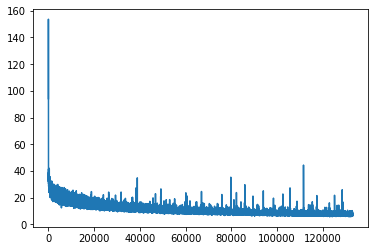

epoch: 72 	 step:0 	 loss: 6.7
epoch: 72 	 step:100 	 loss: 6.779
epoch: 72 	 step:200 	 loss: 7.353
epoch: 72 	 step:300 	 loss: 6.992
epoch: 72 	 step:400 	 loss: 6.945
epoch: 72 	 step:500 	 loss: 6.73
epoch: 72 	 step:600 	 loss: 8.257
epoch: 72 	 step:700 	 loss: 7.513
epoch: 72 	 step:800 	 loss: 6.604
epoch: 72 	 step:900 	 loss: 7.343
epoch: 72 	 step:1000 	 loss: 6.994
epoch: 72 	 step:1100 	 loss: 7.123
epoch: 72 	 step:1200 	 loss: 7.618
epoch: 72 	 step:1300 	 loss: 8.125
epoch: 72 	 step:1400 	 loss: 8.088
epoch: 72 	 step:1500 	 loss: 8.706
epoch: 72 	 step:1600 	 loss: 8.441
epoch: 72 	 step:1700 	 loss: 7.887
epoch: 72 	 step:1800 	 loss: 7.353


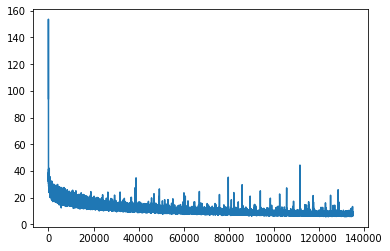

epoch: 73 	 step:0 	 loss: 6.444
epoch: 73 	 step:100 	 loss: 6.979
epoch: 73 	 step:200 	 loss: 7.841
epoch: 73 	 step:300 	 loss: 7.398
epoch: 73 	 step:400 	 loss: 7.146
epoch: 73 	 step:500 	 loss: 7.214
epoch: 73 	 step:600 	 loss: 7.083
epoch: 73 	 step:700 	 loss: 7.278
epoch: 73 	 step:800 	 loss: 7.41
epoch: 73 	 step:900 	 loss: 7.386
epoch: 73 	 step:1000 	 loss: 7.888
epoch: 73 	 step:1100 	 loss: 6.928
epoch: 73 	 step:1200 	 loss: 7.276
epoch: 73 	 step:1300 	 loss: 6.767
epoch: 73 	 step:1400 	 loss: 7.339
epoch: 73 	 step:1500 	 loss: 6.85
epoch: 73 	 step:1600 	 loss: 6.963
epoch: 73 	 step:1700 	 loss: 6.751
epoch: 73 	 step:1800 	 loss: 7.275


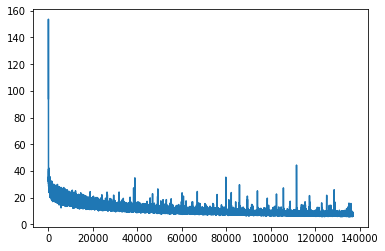

epoch: 74 	 step:0 	 loss: 7.876
epoch: 74 	 step:100 	 loss: 9.923
epoch: 74 	 step:200 	 loss: 7.859
epoch: 74 	 step:300 	 loss: 6.612
epoch: 74 	 step:400 	 loss: 6.509
epoch: 74 	 step:500 	 loss: 7.666
epoch: 74 	 step:600 	 loss: 6.905
epoch: 74 	 step:700 	 loss: 7.103
epoch: 74 	 step:800 	 loss: 7.346
epoch: 74 	 step:900 	 loss: 7.779
epoch: 74 	 step:1000 	 loss: 7.406
epoch: 74 	 step:1100 	 loss: 6.913
epoch: 74 	 step:1200 	 loss: 6.929
epoch: 74 	 step:1300 	 loss: 7.311
epoch: 74 	 step:1400 	 loss: 6.437
epoch: 74 	 step:1500 	 loss: 6.388
epoch: 74 	 step:1600 	 loss: 8.223
epoch: 74 	 step:1700 	 loss: 7.692
epoch: 74 	 step:1800 	 loss: 6.743


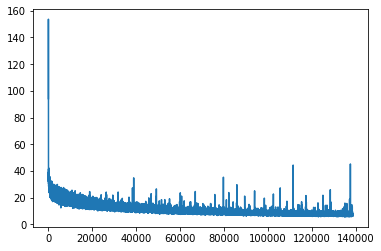

epoch: 75 	 step:0 	 loss: 6.968
epoch: 75 	 step:100 	 loss: 8.415
epoch: 75 	 step:200 	 loss: 7.34
epoch: 75 	 step:300 	 loss: 6.427
epoch: 75 	 step:400 	 loss: 7.038
epoch: 75 	 step:500 	 loss: 6.37
epoch: 75 	 step:600 	 loss: 7.156
epoch: 75 	 step:700 	 loss: 6.673
epoch: 75 	 step:800 	 loss: 6.735
epoch: 75 	 step:900 	 loss: 6.761
epoch: 75 	 step:1000 	 loss: 7.025
epoch: 75 	 step:1100 	 loss: 7.423
epoch: 75 	 step:1200 	 loss: 6.605
epoch: 75 	 step:1300 	 loss: 7.017
epoch: 75 	 step:1400 	 loss: 6.798
epoch: 75 	 step:1500 	 loss: 6.923
epoch: 75 	 step:1600 	 loss: 6.765
epoch: 75 	 step:1700 	 loss: 7.032
epoch: 75 	 step:1800 	 loss: 8.03


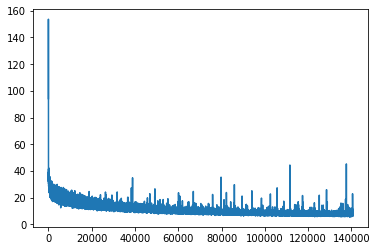

epoch: 76 	 step:0 	 loss: 7.405
epoch: 76 	 step:100 	 loss: 6.715
epoch: 76 	 step:200 	 loss: 6.035
epoch: 76 	 step:300 	 loss: 7.702
epoch: 76 	 step:400 	 loss: 6.984
epoch: 76 	 step:500 	 loss: 7.006
epoch: 76 	 step:600 	 loss: 6.709
epoch: 76 	 step:700 	 loss: 7.094
epoch: 76 	 step:800 	 loss: 6.736
epoch: 76 	 step:900 	 loss: 6.863
epoch: 76 	 step:1000 	 loss: 7.341
epoch: 76 	 step:1100 	 loss: 6.663
epoch: 76 	 step:1200 	 loss: 6.572
epoch: 76 	 step:1300 	 loss: 6.37
epoch: 76 	 step:1400 	 loss: 6.915
epoch: 76 	 step:1500 	 loss: 7.583
epoch: 76 	 step:1600 	 loss: 8.681
epoch: 76 	 step:1700 	 loss: 6.179
epoch: 76 	 step:1800 	 loss: 7.083


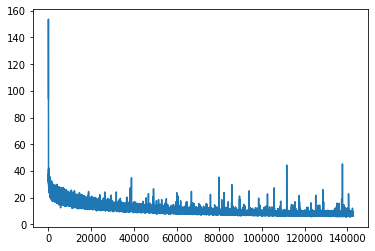

epoch: 77 	 step:0 	 loss: 6.943
epoch: 77 	 step:100 	 loss: 6.584
epoch: 77 	 step:200 	 loss: 7.005
epoch: 77 	 step:300 	 loss: 6.711
epoch: 77 	 step:400 	 loss: 7.956
epoch: 77 	 step:500 	 loss: 7.111
epoch: 77 	 step:600 	 loss: 6.764
epoch: 77 	 step:700 	 loss: 6.932
epoch: 77 	 step:800 	 loss: 6.716
epoch: 77 	 step:900 	 loss: 6.668
epoch: 77 	 step:1000 	 loss: 6.512
epoch: 77 	 step:1100 	 loss: 6.798
epoch: 77 	 step:1200 	 loss: 6.259
epoch: 77 	 step:1300 	 loss: 7.882
epoch: 77 	 step:1400 	 loss: 7.334
epoch: 77 	 step:1500 	 loss: 6.689
epoch: 77 	 step:1600 	 loss: 7.525
epoch: 77 	 step:1700 	 loss: 6.923
epoch: 77 	 step:1800 	 loss: 6.348


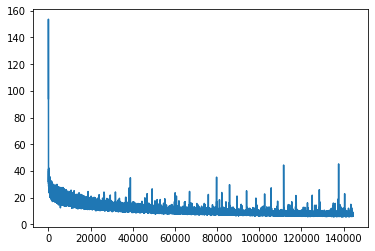

epoch: 78 	 step:0 	 loss: 6.809
epoch: 78 	 step:100 	 loss: 5.945
epoch: 78 	 step:200 	 loss: 7.06
epoch: 78 	 step:300 	 loss: 6.698
epoch: 78 	 step:400 	 loss: 6.551
epoch: 78 	 step:500 	 loss: 7.006
epoch: 78 	 step:600 	 loss: 6.355
epoch: 78 	 step:700 	 loss: 7.176
epoch: 78 	 step:800 	 loss: 6.256
epoch: 78 	 step:900 	 loss: 6.964
epoch: 78 	 step:1000 	 loss: 6.503
epoch: 78 	 step:1100 	 loss: 7.655
epoch: 78 	 step:1200 	 loss: 7.813
epoch: 78 	 step:1300 	 loss: 7.39
epoch: 78 	 step:1400 	 loss: 6.995
epoch: 78 	 step:1500 	 loss: 7.345
epoch: 78 	 step:1600 	 loss: 7.094
epoch: 78 	 step:1700 	 loss: 7.209
epoch: 78 	 step:1800 	 loss: 7.395


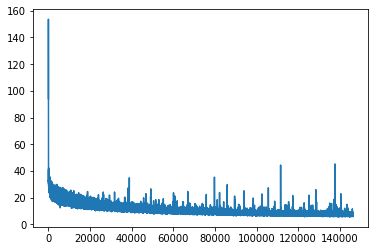

epoch: 79 	 step:0 	 loss: 6.494
epoch: 79 	 step:100 	 loss: 6.597
epoch: 79 	 step:200 	 loss: 6.166
epoch: 79 	 step:300 	 loss: 6.935
epoch: 79 	 step:400 	 loss: 6.917
epoch: 79 	 step:500 	 loss: 6.61
epoch: 79 	 step:600 	 loss: 6.632
epoch: 79 	 step:700 	 loss: 6.717
epoch: 79 	 step:800 	 loss: 6.901
epoch: 79 	 step:900 	 loss: 6.32
epoch: 79 	 step:1000 	 loss: 8.119
epoch: 79 	 step:1100 	 loss: 6.861
epoch: 79 	 step:1200 	 loss: 7.432
epoch: 79 	 step:1300 	 loss: 7.061
epoch: 79 	 step:1400 	 loss: 7.506
epoch: 79 	 step:1500 	 loss: 6.107
epoch: 79 	 step:1600 	 loss: 6.521
epoch: 79 	 step:1700 	 loss: 6.844
epoch: 79 	 step:1800 	 loss: 6.646


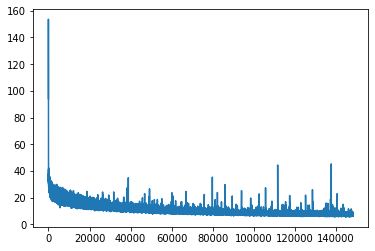

epoch: 80 	 step:0 	 loss: 6.391
epoch: 80 	 step:100 	 loss: 7.229
epoch: 80 	 step:200 	 loss: 6.383
epoch: 80 	 step:300 	 loss: 6.621
epoch: 80 	 step:400 	 loss: 6.775
epoch: 80 	 step:500 	 loss: 7.806
epoch: 80 	 step:600 	 loss: 8.455
epoch: 80 	 step:700 	 loss: 7.167
epoch: 80 	 step:800 	 loss: 7.168
epoch: 80 	 step:900 	 loss: 6.641
epoch: 80 	 step:1000 	 loss: 7.238
epoch: 80 	 step:1100 	 loss: 6.778
epoch: 80 	 step:1200 	 loss: 5.943
epoch: 80 	 step:1300 	 loss: 7.063
epoch: 80 	 step:1400 	 loss: 7.282
epoch: 80 	 step:1500 	 loss: 6.289
epoch: 80 	 step:1600 	 loss: 6.979
epoch: 80 	 step:1700 	 loss: 6.757
epoch: 80 	 step:1800 	 loss: 6.692


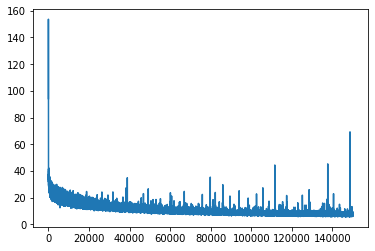

epoch: 81 	 step:0 	 loss: 6.494
epoch: 81 	 step:100 	 loss: 6.813
epoch: 81 	 step:200 	 loss: 6.573
epoch: 81 	 step:300 	 loss: 7.055
epoch: 81 	 step:400 	 loss: 7.296
epoch: 81 	 step:500 	 loss: 6.206
epoch: 81 	 step:600 	 loss: 6.841
epoch: 81 	 step:700 	 loss: 7.016
epoch: 81 	 step:800 	 loss: 7.158
epoch: 81 	 step:900 	 loss: 6.179
epoch: 81 	 step:1000 	 loss: 7.146
epoch: 81 	 step:1100 	 loss: 8.277
epoch: 81 	 step:1200 	 loss: 7.01
epoch: 81 	 step:1300 	 loss: 6.53
epoch: 81 	 step:1400 	 loss: 7.053
epoch: 81 	 step:1500 	 loss: 6.711
epoch: 81 	 step:1600 	 loss: 6.783
epoch: 81 	 step:1700 	 loss: 6.599
epoch: 81 	 step:1800 	 loss: 6.186


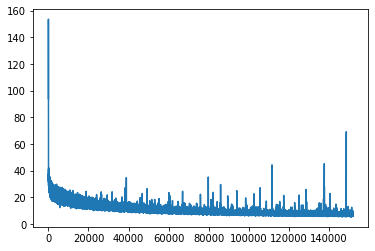

epoch: 82 	 step:0 	 loss: 6.794
epoch: 82 	 step:100 	 loss: 6.908
epoch: 82 	 step:200 	 loss: 7.468
epoch: 82 	 step:300 	 loss: 6.737
epoch: 82 	 step:400 	 loss: 7.015
epoch: 82 	 step:500 	 loss: 6.267
epoch: 82 	 step:600 	 loss: 6.157
epoch: 82 	 step:700 	 loss: 7.407
epoch: 82 	 step:800 	 loss: 6.749
epoch: 82 	 step:900 	 loss: 7.052
epoch: 82 	 step:1000 	 loss: 7.135
epoch: 82 	 step:1100 	 loss: 7.058
epoch: 82 	 step:1200 	 loss: 6.632
epoch: 82 	 step:1300 	 loss: 7.361
epoch: 82 	 step:1400 	 loss: 6.2
epoch: 82 	 step:1500 	 loss: 7.372
epoch: 82 	 step:1600 	 loss: 7.338
epoch: 82 	 step:1700 	 loss: 7.189
epoch: 82 	 step:1800 	 loss: 6.255


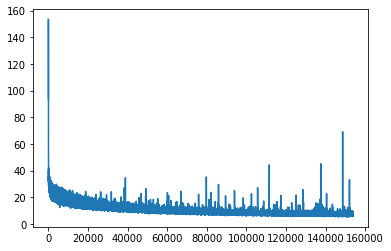

epoch: 83 	 step:0 	 loss: 6.271
epoch: 83 	 step:100 	 loss: 5.819
epoch: 83 	 step:200 	 loss: 6.589
epoch: 83 	 step:300 	 loss: 6.029
epoch: 83 	 step:400 	 loss: 5.811
epoch: 83 	 step:500 	 loss: 8.408
epoch: 83 	 step:600 	 loss: 6.438
epoch: 83 	 step:700 	 loss: 7.228
epoch: 83 	 step:800 	 loss: 7.503
epoch: 83 	 step:900 	 loss: 6.874
epoch: 83 	 step:1000 	 loss: 7.113
epoch: 83 	 step:1100 	 loss: 7.313
epoch: 83 	 step:1200 	 loss: 6.898
epoch: 83 	 step:1300 	 loss: 7.164
epoch: 83 	 step:1400 	 loss: 6.57
epoch: 83 	 step:1500 	 loss: 7.155
epoch: 83 	 step:1600 	 loss: 7.405
epoch: 83 	 step:1700 	 loss: 7.899
epoch: 83 	 step:1800 	 loss: 7.112


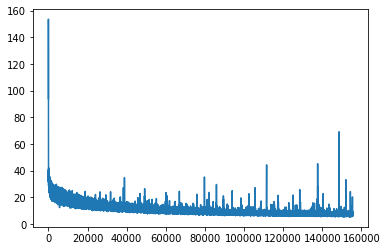

epoch: 84 	 step:0 	 loss: 6.703
epoch: 84 	 step:100 	 loss: 7.106
epoch: 84 	 step:200 	 loss: 6.67
epoch: 84 	 step:300 	 loss: 6.905
epoch: 84 	 step:400 	 loss: 6.764
epoch: 84 	 step:500 	 loss: 7.094
epoch: 84 	 step:600 	 loss: 6.155
epoch: 84 	 step:700 	 loss: 7.447
epoch: 84 	 step:800 	 loss: 6.637
epoch: 84 	 step:900 	 loss: 6.267
epoch: 84 	 step:1000 	 loss: 6.705
epoch: 84 	 step:1100 	 loss: 7.407
epoch: 84 	 step:1200 	 loss: 7.302
epoch: 84 	 step:1300 	 loss: 7.013
epoch: 84 	 step:1400 	 loss: 6.142
epoch: 84 	 step:1500 	 loss: 6.689
epoch: 84 	 step:1600 	 loss: 7.112
epoch: 84 	 step:1700 	 loss: 7.074
epoch: 84 	 step:1800 	 loss: 6.625


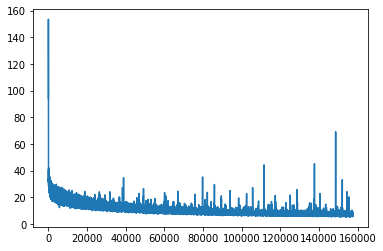

epoch: 85 	 step:0 	 loss: 7.218
epoch: 85 	 step:100 	 loss: 7.027
epoch: 85 	 step:200 	 loss: 6.987
epoch: 85 	 step:300 	 loss: 6.78
epoch: 85 	 step:400 	 loss: 6.344
epoch: 85 	 step:500 	 loss: 6.339
epoch: 85 	 step:600 	 loss: 6.719
epoch: 85 	 step:700 	 loss: 6.546
epoch: 85 	 step:800 	 loss: 6.1
epoch: 85 	 step:900 	 loss: 6.517
epoch: 85 	 step:1000 	 loss: 6.862
epoch: 85 	 step:1100 	 loss: 7.398
epoch: 85 	 step:1200 	 loss: 7.09
epoch: 85 	 step:1300 	 loss: 6.539
epoch: 85 	 step:1400 	 loss: 7.421
epoch: 85 	 step:1500 	 loss: 7.235
epoch: 85 	 step:1600 	 loss: 6.232
epoch: 85 	 step:1700 	 loss: 6.724
epoch: 85 	 step:1800 	 loss: 10.97


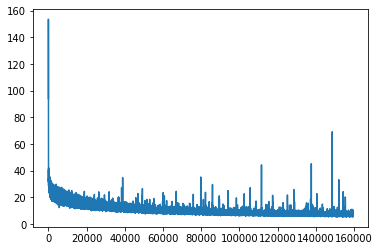

epoch: 86 	 step:0 	 loss: 7.059
epoch: 86 	 step:100 	 loss: 7.287
epoch: 86 	 step:200 	 loss: 6.255
epoch: 86 	 step:300 	 loss: 6.648
epoch: 86 	 step:400 	 loss: 6.813
epoch: 86 	 step:500 	 loss: 6.836
epoch: 86 	 step:600 	 loss: 5.764
epoch: 86 	 step:700 	 loss: 7.777
epoch: 86 	 step:800 	 loss: 6.781
epoch: 86 	 step:900 	 loss: 6.272
epoch: 86 	 step:1000 	 loss: 6.452
epoch: 86 	 step:1100 	 loss: 7.924
epoch: 86 	 step:1200 	 loss: 7.433
epoch: 86 	 step:1300 	 loss: 6.401
epoch: 86 	 step:1400 	 loss: 6.742
epoch: 86 	 step:1500 	 loss: 6.8
epoch: 86 	 step:1600 	 loss: 7.424
epoch: 86 	 step:1700 	 loss: 7.3
epoch: 86 	 step:1800 	 loss: 6.245


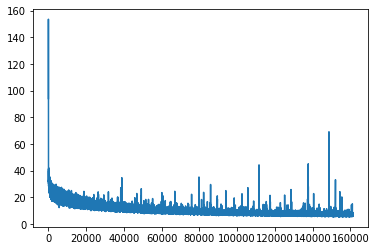

epoch: 87 	 step:0 	 loss: 6.584
epoch: 87 	 step:100 	 loss: 6.527
epoch: 87 	 step:200 	 loss: 7.508
epoch: 87 	 step:300 	 loss: 6.482
epoch: 87 	 step:400 	 loss: 6.975
epoch: 87 	 step:500 	 loss: 6.62
epoch: 87 	 step:600 	 loss: 6.364
epoch: 87 	 step:700 	 loss: 6.655
epoch: 87 	 step:800 	 loss: 6.604
epoch: 87 	 step:900 	 loss: 6.396
epoch: 87 	 step:1000 	 loss: 6.154
epoch: 87 	 step:1100 	 loss: 6.247
epoch: 87 	 step:1200 	 loss: 8.418
epoch: 87 	 step:1300 	 loss: 7.016
epoch: 87 	 step:1400 	 loss: 8.219
epoch: 87 	 step:1500 	 loss: 6.218
epoch: 87 	 step:1600 	 loss: 6.808
epoch: 87 	 step:1700 	 loss: 6.342
epoch: 87 	 step:1800 	 loss: 7.362


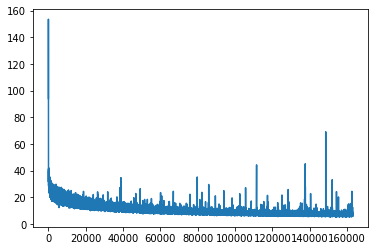

epoch: 88 	 step:0 	 loss: 6.486
epoch: 88 	 step:100 	 loss: 7.249
epoch: 88 	 step:200 	 loss: 6.616
epoch: 88 	 step:300 	 loss: 6.891
epoch: 88 	 step:400 	 loss: 6.38
epoch: 88 	 step:500 	 loss: 7.013
epoch: 88 	 step:600 	 loss: 6.262
epoch: 88 	 step:700 	 loss: 7.309
epoch: 88 	 step:800 	 loss: 6.593
epoch: 88 	 step:900 	 loss: 6.898
epoch: 88 	 step:1000 	 loss: 6.095
epoch: 88 	 step:1100 	 loss: 7.496
epoch: 88 	 step:1200 	 loss: 5.944
epoch: 88 	 step:1300 	 loss: 7.63
epoch: 88 	 step:1400 	 loss: 6.931
epoch: 88 	 step:1500 	 loss: 7.094
epoch: 88 	 step:1600 	 loss: 6.721
epoch: 88 	 step:1700 	 loss: 6.975
epoch: 88 	 step:1800 	 loss: 6.532


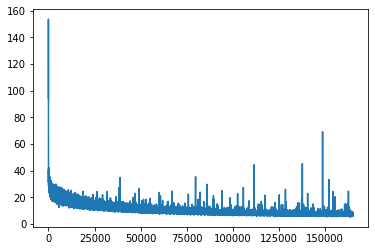

epoch: 89 	 step:0 	 loss: 8.028
epoch: 89 	 step:100 	 loss: 6.539
epoch: 89 	 step:200 	 loss: 5.934
epoch: 89 	 step:300 	 loss: 6.549
epoch: 89 	 step:400 	 loss: 8.236
epoch: 89 	 step:500 	 loss: 6.452
epoch: 89 	 step:600 	 loss: 6.007
epoch: 89 	 step:700 	 loss: 6.46
epoch: 89 	 step:800 	 loss: 6.133
epoch: 89 	 step:900 	 loss: 6.495
epoch: 89 	 step:1000 	 loss: 6.744
epoch: 89 	 step:1100 	 loss: 6.601
epoch: 89 	 step:1200 	 loss: 7.131
epoch: 89 	 step:1300 	 loss: 7.301
epoch: 89 	 step:1400 	 loss: 6.757
epoch: 89 	 step:1500 	 loss: 6.795
epoch: 89 	 step:1600 	 loss: 7.425
epoch: 89 	 step:1700 	 loss: 6.775
epoch: 89 	 step:1800 	 loss: 6.916


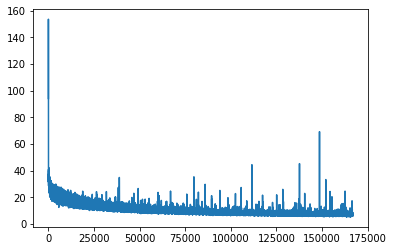

epoch: 90 	 step:0 	 loss: 6.184
epoch: 90 	 step:100 	 loss: 6.529
epoch: 90 	 step:200 	 loss: 6.116
epoch: 90 	 step:300 	 loss: 7.317
epoch: 90 	 step:400 	 loss: 6.709
epoch: 90 	 step:500 	 loss: 6.608
epoch: 90 	 step:600 	 loss: 8.247
epoch: 90 	 step:700 	 loss: 6.91
epoch: 90 	 step:800 	 loss: 6.485
epoch: 90 	 step:900 	 loss: 5.756
epoch: 90 	 step:1000 	 loss: 7.355
epoch: 90 	 step:1100 	 loss: 7.369
epoch: 90 	 step:1200 	 loss: 6.698
epoch: 90 	 step:1300 	 loss: 7.095
epoch: 90 	 step:1400 	 loss: 7.12
epoch: 90 	 step:1500 	 loss: 6.882
epoch: 90 	 step:1600 	 loss: 6.616
epoch: 90 	 step:1700 	 loss: 6.542
epoch: 90 	 step:1800 	 loss: 6.393


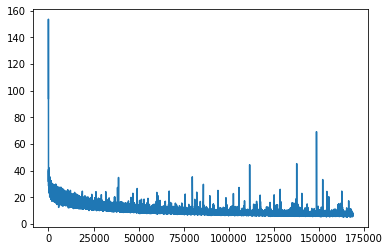

epoch: 91 	 step:0 	 loss: 6.941
epoch: 91 	 step:100 	 loss: 6.366
epoch: 91 	 step:200 	 loss: 6.493
epoch: 91 	 step:300 	 loss: 6.09
epoch: 91 	 step:400 	 loss: 6.447
epoch: 91 	 step:500 	 loss: 6.432
epoch: 91 	 step:600 	 loss: 7.254
epoch: 91 	 step:700 	 loss: 7.538
epoch: 91 	 step:800 	 loss: 7.121
epoch: 91 	 step:900 	 loss: 6.859
epoch: 91 	 step:1000 	 loss: 6.455
epoch: 91 	 step:1100 	 loss: 6.735
epoch: 91 	 step:1200 	 loss: 6.854
epoch: 91 	 step:1300 	 loss: 6.783
epoch: 91 	 step:1400 	 loss: 6.601
epoch: 91 	 step:1500 	 loss: 6.8
epoch: 91 	 step:1600 	 loss: 7.964
epoch: 91 	 step:1700 	 loss: 6.866
epoch: 91 	 step:1800 	 loss: 6.982


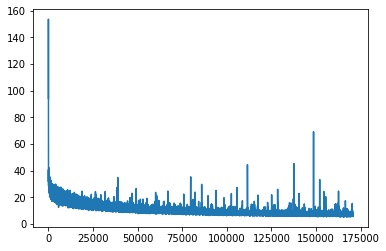

epoch: 92 	 step:0 	 loss: 6.493
epoch: 92 	 step:100 	 loss: 6.136
epoch: 92 	 step:200 	 loss: 6.477
epoch: 92 	 step:300 	 loss: 6.945
epoch: 92 	 step:400 	 loss: 6.62
epoch: 92 	 step:500 	 loss: 6.055
epoch: 92 	 step:600 	 loss: 5.889
epoch: 92 	 step:700 	 loss: 6.377
epoch: 92 	 step:800 	 loss: 6.547
epoch: 92 	 step:900 	 loss: 6.64
epoch: 92 	 step:1000 	 loss: 6.766
epoch: 92 	 step:1100 	 loss: 6.973
epoch: 92 	 step:1200 	 loss: 7.066
epoch: 92 	 step:1300 	 loss: 7.394
epoch: 92 	 step:1400 	 loss: 6.391
epoch: 92 	 step:1500 	 loss: 6.61
epoch: 92 	 step:1600 	 loss: 7.665
epoch: 92 	 step:1700 	 loss: 5.97
epoch: 92 	 step:1800 	 loss: 6.12


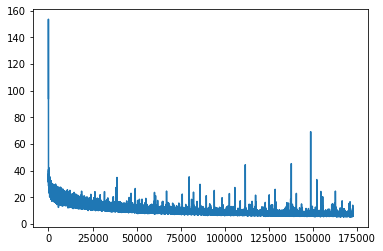

epoch: 93 	 step:0 	 loss: 7.0
epoch: 93 	 step:100 	 loss: 6.028
epoch: 93 	 step:200 	 loss: 6.791
epoch: 93 	 step:300 	 loss: 5.697
epoch: 93 	 step:400 	 loss: 6.459
epoch: 93 	 step:500 	 loss: 6.292
epoch: 93 	 step:600 	 loss: 5.946
epoch: 93 	 step:700 	 loss: 6.759
epoch: 93 	 step:800 	 loss: 5.787
epoch: 93 	 step:900 	 loss: 6.72
epoch: 93 	 step:1000 	 loss: 6.08
epoch: 93 	 step:1100 	 loss: 6.648
epoch: 93 	 step:1200 	 loss: 6.125
epoch: 93 	 step:1300 	 loss: 6.529
epoch: 93 	 step:1400 	 loss: 7.195
epoch: 93 	 step:1500 	 loss: 6.274
epoch: 93 	 step:1600 	 loss: 6.172
epoch: 93 	 step:1700 	 loss: 6.909
epoch: 93 	 step:1800 	 loss: 6.92


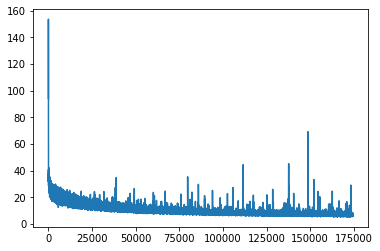

epoch: 94 	 step:0 	 loss: 6.16
epoch: 94 	 step:100 	 loss: 6.081
epoch: 94 	 step:200 	 loss: 6.099
epoch: 94 	 step:300 	 loss: 6.971
epoch: 94 	 step:400 	 loss: 7.493
epoch: 94 	 step:500 	 loss: 6.021
epoch: 94 	 step:600 	 loss: 6.39
epoch: 94 	 step:700 	 loss: 8.017
epoch: 94 	 step:800 	 loss: 6.086
epoch: 94 	 step:900 	 loss: 7.321
epoch: 94 	 step:1000 	 loss: 5.605
epoch: 94 	 step:1100 	 loss: 6.492
epoch: 94 	 step:1200 	 loss: 7.399
epoch: 94 	 step:1300 	 loss: 5.951
epoch: 94 	 step:1400 	 loss: 5.878
epoch: 94 	 step:1500 	 loss: 7.569
epoch: 94 	 step:1600 	 loss: 6.618
epoch: 94 	 step:1700 	 loss: 7.785
epoch: 94 	 step:1800 	 loss: 6.312


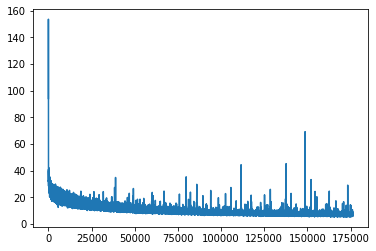

epoch: 95 	 step:0 	 loss: 6.235
epoch: 95 	 step:100 	 loss: 6.33
epoch: 95 	 step:200 	 loss: 6.349
epoch: 95 	 step:300 	 loss: 6.457
epoch: 95 	 step:400 	 loss: 6.088
epoch: 95 	 step:500 	 loss: 5.749
epoch: 95 	 step:600 	 loss: 6.127
epoch: 95 	 step:700 	 loss: 7.175
epoch: 95 	 step:800 	 loss: 6.507
epoch: 95 	 step:900 	 loss: 6.722
epoch: 95 	 step:1000 	 loss: 7.186
epoch: 95 	 step:1100 	 loss: 6.658
epoch: 95 	 step:1200 	 loss: 6.131
epoch: 95 	 step:1300 	 loss: 7.908
epoch: 95 	 step:1400 	 loss: 5.67
epoch: 95 	 step:1500 	 loss: 6.593
epoch: 95 	 step:1600 	 loss: 6.207
epoch: 95 	 step:1700 	 loss: 6.732
epoch: 95 	 step:1800 	 loss: 8.116


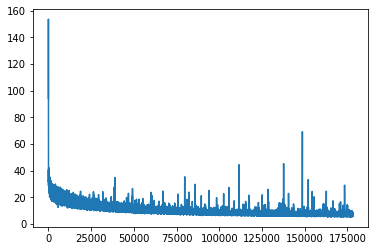

epoch: 96 	 step:0 	 loss: 6.03
epoch: 96 	 step:100 	 loss: 6.855
epoch: 96 	 step:200 	 loss: 7.269
epoch: 96 	 step:300 	 loss: 6.486
epoch: 96 	 step:400 	 loss: 6.29
epoch: 96 	 step:500 	 loss: 7.608
epoch: 96 	 step:600 	 loss: 6.488
epoch: 96 	 step:700 	 loss: 6.811
epoch: 96 	 step:800 	 loss: 6.695
epoch: 96 	 step:900 	 loss: 6.225
epoch: 96 	 step:1000 	 loss: 6.044
epoch: 96 	 step:1100 	 loss: 6.636
epoch: 96 	 step:1200 	 loss: 6.393
epoch: 96 	 step:1300 	 loss: 6.274
epoch: 96 	 step:1400 	 loss: 6.826
epoch: 96 	 step:1500 	 loss: 7.211
epoch: 96 	 step:1600 	 loss: 6.665
epoch: 96 	 step:1700 	 loss: 6.892
epoch: 96 	 step:1800 	 loss: 7.068


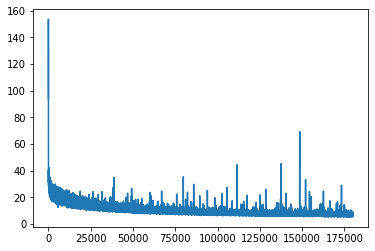

epoch: 97 	 step:0 	 loss: 6.497
epoch: 97 	 step:100 	 loss: 7.034
epoch: 97 	 step:200 	 loss: 6.235
epoch: 97 	 step:300 	 loss: 6.424
epoch: 97 	 step:400 	 loss: 7.69
epoch: 97 	 step:500 	 loss: 6.842
epoch: 97 	 step:600 	 loss: 7.662
epoch: 97 	 step:700 	 loss: 6.563
epoch: 97 	 step:800 	 loss: 6.669
epoch: 97 	 step:900 	 loss: 6.565
epoch: 97 	 step:1000 	 loss: 7.199
epoch: 97 	 step:1100 	 loss: 6.781
epoch: 97 	 step:1200 	 loss: 7.75
epoch: 97 	 step:1300 	 loss: 6.272
epoch: 97 	 step:1400 	 loss: 6.523
epoch: 97 	 step:1500 	 loss: 6.369
epoch: 97 	 step:1600 	 loss: 6.812
epoch: 97 	 step:1700 	 loss: 7.063
epoch: 97 	 step:1800 	 loss: 6.396


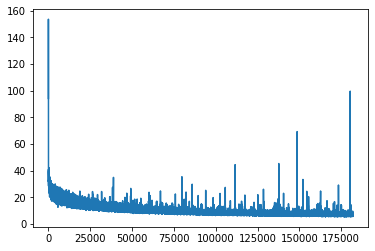

epoch: 98 	 step:0 	 loss: 6.107
epoch: 98 	 step:100 	 loss: 6.507
epoch: 98 	 step:200 	 loss: 5.887
epoch: 98 	 step:300 	 loss: 6.532
epoch: 98 	 step:400 	 loss: 6.135
epoch: 98 	 step:500 	 loss: 6.144
epoch: 98 	 step:600 	 loss: 6.334
epoch: 98 	 step:700 	 loss: 6.539
epoch: 98 	 step:800 	 loss: 6.809
epoch: 98 	 step:900 	 loss: 5.753
epoch: 98 	 step:1000 	 loss: 6.597
epoch: 98 	 step:1100 	 loss: 7.012
epoch: 98 	 step:1200 	 loss: 6.644
epoch: 98 	 step:1300 	 loss: 8.421
epoch: 98 	 step:1400 	 loss: 6.448
epoch: 98 	 step:1500 	 loss: 7.364
epoch: 98 	 step:1600 	 loss: 7.064
epoch: 98 	 step:1700 	 loss: 6.873
epoch: 98 	 step:1800 	 loss: 6.38


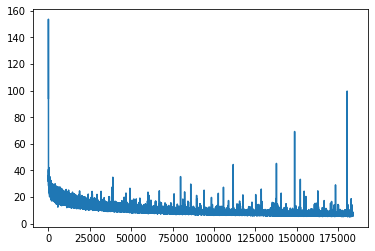

epoch: 99 	 step:0 	 loss: 6.082
epoch: 99 	 step:100 	 loss: 6.109
epoch: 99 	 step:200 	 loss: 5.543
epoch: 99 	 step:300 	 loss: 5.466
epoch: 99 	 step:400 	 loss: 6.83
epoch: 99 	 step:500 	 loss: 6.614
epoch: 99 	 step:600 	 loss: 7.358
epoch: 99 	 step:700 	 loss: 5.935
epoch: 99 	 step:800 	 loss: 6.948
epoch: 99 	 step:900 	 loss: 6.795
epoch: 99 	 step:1000 	 loss: 6.166
epoch: 99 	 step:1100 	 loss: 6.455
epoch: 99 	 step:1200 	 loss: 6.466
epoch: 99 	 step:1300 	 loss: 5.988
epoch: 99 	 step:1400 	 loss: 6.383
epoch: 99 	 step:1500 	 loss: 6.438
epoch: 99 	 step:1600 	 loss: 7.541
epoch: 99 	 step:1700 	 loss: 5.942
epoch: 99 	 step:1800 	 loss: 7.862


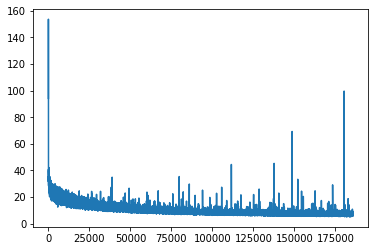

epoch: 100 	 step:0 	 loss: 5.969
epoch: 100 	 step:100 	 loss: 6.977
epoch: 100 	 step:200 	 loss: 5.742
epoch: 100 	 step:300 	 loss: 6.769
epoch: 100 	 step:400 	 loss: 5.877
epoch: 100 	 step:500 	 loss: 6.806
epoch: 100 	 step:600 	 loss: 6.596
epoch: 100 	 step:700 	 loss: 5.915
epoch: 100 	 step:800 	 loss: 6.348
epoch: 100 	 step:900 	 loss: 5.999
epoch: 100 	 step:1000 	 loss: 6.934
epoch: 100 	 step:1100 	 loss: 6.333
epoch: 100 	 step:1200 	 loss: 5.548
epoch: 100 	 step:1300 	 loss: 6.441
epoch: 100 	 step:1400 	 loss: 6.398
epoch: 100 	 step:1500 	 loss: 6.263
epoch: 100 	 step:1600 	 loss: 6.673
epoch: 100 	 step:1700 	 loss: 6.911
epoch: 100 	 step:1800 	 loss: 7.011


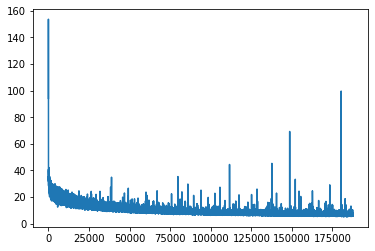

In [17]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [18]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        magn, _ = calc_fourier(data)
        out_vec = model(magn)
        out_ft = (magn[..., None]  * out_vec) / (torch.norm(out_vec, dim=-1) + 1e-16)[..., None] 
        out = torch.irfft(out_ft, 2, onesided=False)#, signal_sizes=(data.shape[-2], data.shape[-1]))
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [19]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


In [24]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open("../cache/e2e/pppe-{}e_original.p".format(num_epochs), "wb"))
pickle.dump(test_predicted, open("../cache/e2e/pppe-{}e.p".format(num_epochs), "wb"))

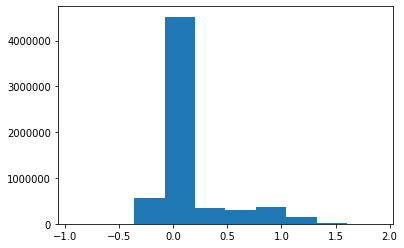

In [19]:
plt.hist(test_predicted.reshape(-1))
plt.show()

Produces negative values!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


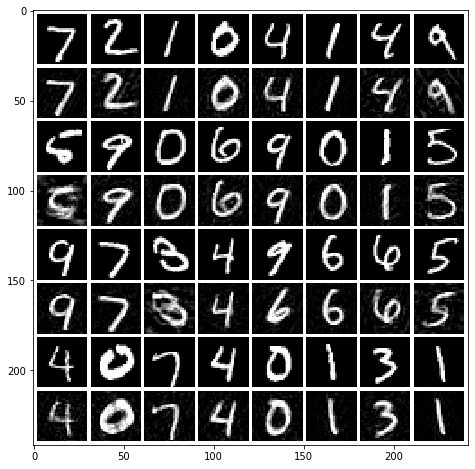

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


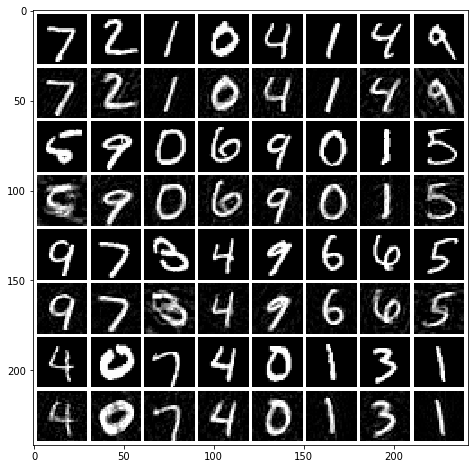

In [20]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/vec-dist.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/vec-dist-reg.png")

In [20]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.026200029086567156, std: 0.020798186541353052
  MAE: 0.0953508759575925, std: 0.03704167648032855
  SSIM: 0.6691470691136859, std: 0.14616190016832306
  Sharpness: 0.16895339827071348, std: 0.04704465665266345
  PhCo-MSE: 0.025128007987405, std: 0.020898607099473932
  PhCo-MAE: 0.09409213312937936, std: 0.037132485158869084
  PhCo-SSIM: 0.6729288173341703, std: 0.14299055681995718
  CroCo-MSE: 0.019472620146416375, std: 0.011761553487763629
  CroCo-MAE: 0.08708360352648015, std: 0.030176171813849705
  CroCo-SSIM: 0.708358105612404, std: 0.10768115420695881

Magnitude error:
  MSE Magnitude: 4.343468765000369e-05, std: 0.00038721225654291203

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.75, 1.73] - should be in [0, 1]

Markdown table values:
 0.02620 | 0.09535 | 0.6691 | 0.1690 | 0.02513 | 0.09409 | 0.6729 | 0.01947 | 0.08708 | 0.7084 | 0.00004343 |


## Evaluation for different FC  (1024 samples)


#### Magnitude weight 


| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Fourier MSE | 2048 | 50 | 0.02593 | 0.09596 | 0.6644 | 0.1707 | 0.02586 | 0.09590 | 0.6622 | 0.01941 | 0.08785 | 0.7024 | 0.0001058 |
| 2 | Fourier MSE | 2048 | 100 | 0.02587 | 0.09481 | 0.6715 | 0.1678 | 0.02499 | 0.09378 | 0.6743 | 0.01910 | 0.08642 | 0.7115 | 0.00003887 |

Signal error:
  MSE: 0.025866893585998696, std: 0.02042988174438707
  MAE: 0.09480974730286107, std: 0.036475752798265704
  SSIM: 0.6714995185052364, std: 0.14488206955519162
  Sharpness: 0.16775582271122086, std: 0.04682198810331356
  PhCo-MSE: 0.02498573136858795, std: 0.020847286766282766
  PhCo-MAE: 0.09378048750841117, std: 0.036809456143369904
  PhCo-SSIM: 0.6742725788909549, std: 0.140784145408516
  CroCo-MSE: 0.019104920509107615, std: 0.011310974968338558
  CroCo-MAE: 0.08641711583004508, std: 0.029726059074874345
  CroCo-SSIM: 0.7115441086165087, std: 0.10421048217031495

Magnitude error:
  MSE Magnitude: 3.887095466291235e-05, std: 0.0003727924794279073

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.85, 1.79] - should be in [0, 1]

#### No Magnitude weight 


| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | Fourier MSE | 2048 | 50 | 0.02893 | 0.1016 | 0.6422 | 0.1701 | 0.02818 | 0.1005 | 0.6467 | 0.02226 | 0.09357 | 0.6794 | 0.00004724 |
